# Прогнозирование оттока клиентов. Оператор связи «Ниединогоразрыва.ком»

# Задача
- сформировать общий датафрейм
- закодировать признаки
- сформировать датасеты для обучения
    - обучающая
    - тестовая
- Модель 1:
    - обучение
    - настройка гиперпараметров
- Модель 2 (бустинг):
    - обучение
    - настройка гиперпараметров
- Выводы

ковариационную матрицу

добавить графики рок аук для наглядности

In [53]:
seed = 120922

In [324]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, SelectKBest
from sklearn.utils import shuffle


from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, GridSearchCV
import optuna

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from catboost import Pool
from catboost import CatBoostClassifier
from catboost import cv

import xgboost as xgb
import lightgbm as lgb

from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, accuracy_score

In [10]:
def upsample(features, target, repeat, type):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    if type:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    else:
        features_upsampled = pd.concat([features_zeros] * repeat + [features_ones])
        target_upsampled = pd.concat([target_zeros] * repeat + [target_ones])

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=seed)
    return features_upsampled, target_upsampled

In [22]:
def encode(train, target):
    encoder = OrdinalEncoder()
    nonulls = np.array(train.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = encoder.fit_transform(impute_reshape)
    train.loc[train.notnull()] = np.squeeze(impute_ordinal)

    nonulls = np.array(target.dropna())
    impute_reshape = nonulls.reshape(-1,1)
    impute_ordinal = encoder.transform(impute_reshape)
    target.loc[target.notnull()] = np.squeeze(impute_ordinal)
    return train, target

In [36]:
def all_merge(data):
    """
    объединяет все датафреймы в один
    """
    df = data[0].drop(columns=['BeginDate']).copy()
    for i in data[1:]:
        df = df.merge(i, on='customerID', how='left')
    df.drop(columns=['customerID'], inplace=True)
    return df

In [57]:
def manual_knn(data, categorical_features, numerical_features):
    df = all_merge(data)
    
    # сразу уберем тех пользователей, которые попали на время экспорта данных
    df = df.query('TotalCharges != " "')
    df['TotalCharges'] = df['TotalCharges'].astype('float')
    
    # выносим целевой признак
    target = df['EndDate'].copy()
    df.drop(columns=['EndDate'], inplace=True)

    features_train, features_test, target_train, target_test = train_test_split(df, 
                                                                                target,
                                                                                test_size=0.25,
                                                                                stratify=target,
                                                                                random_state=seed)

    # обработка целевого признака
    target_train.loc[target_train != "No"] = 1
    target_train.loc[target_train == "No"] = 0
    target_test.loc[target_test != "No"] = 1
    target_test.loc[target_test == "No"] = 0
    target_train = target_train.astype('int')
    target_test = target_test.astype('int')

    #categorical features
    # ohe
    for columns in categorical_features:
        encode(features_train[columns], features_test[columns])
    
    #knn
    imputer = KNNImputer()
    features_train = pd.DataFrame(np.round(imputer.fit_transform(features_train)), columns = features_train.columns)
    features_test = pd.DataFrame(np.round(imputer.transform(features_test)), columns = features_test.columns)
    for columns in categorical_features:  # catboost ругается
        features_train[columns] = features_train[columns].astype('int')
        features_test[columns] = features_test[columns].astype('int')
    
    #numerical features
    transformer = MinMaxScaler()
    features_train[numerical_features] = transformer.fit_transform(features_train[numerical_features])
    features_test[numerical_features] = transformer.transform(features_test[numerical_features])

    return features_train, features_test, target_train, target_test

In [545]:
def mentrics_eval(estimator=None, features=None, target=None, predictions=None, base=0, matrix=0, roc=0, proba=0):
    if estimator:
        predictions = estimator.predict(features)
    if base:
        # некоторые модели предсказывают вероятности, поэтому чтобы автоматизировать всегда будет менять здесь на [0,1]
        print(f'''roc_auc of predictions:       {roc_auc_score(target, [1 if i >=0.5 else 0 for i in predictions])}
accuracy_test of predictions: {accuracy_score(target, [1 if i >=0.5 else 0 for i in predictions])}''')
    if matrix:
        ConfusionMatrixDisplay.from_predictions(target, [1 if i >=0.5 else 0 for i in predictions])
    if roc:
        RocCurveDisplay.from_predictions(target, [1 if i >=0.5 else 0 for i in predictions])
    if proba:
        if estimator:
            try:
                probabilities = estimator.predict(features)[:,1]
            except:
                probabilities = estimator.predict_proba(features)[:,1]
        else:
            probabilities = predictions
        RocCurveDisplay.from_predictions(target, probabilities)


In [39]:
def vif_metric(data):
    return pd.Series(
                np.linalg.inv(data.corr().to_numpy()).diagonal(),
                index=data.columns, 
                name='VIF'
           )

In [439]:
def treshhold(x):
    if x >= 0.5:
        return 1
    else:
        return 0

In [15]:
try:
    df_contract = pd.read_csv(
        '/home/qq/Downloads/final_project/final_provider/contract.csv', parse_dates=['BeginDate'])
    df_internet = pd.read_csv(
        '/home/qq/Downloads/final_project/final_provider/internet.csv')
    df_personal = pd.read_csv(
        '/home/qq/Downloads/final_project/final_provider/personal.csv')
    df_phone = pd.read_csv(
        '/home/qq/Downloads/final_project/final_provider/phone.csv')
except:
    
    df_contract = pd.read_csv(
        '/datasets/final_provider/contract.csv', parse_dates=['BeginDate'])
    df_internet = pd.read_csv(
        '/datasets/final_provider/internet.csv')
    df_personal = pd.read_csv(
        '/datasets/final_provider/personal.csv')
    df_phone = pd.read_csv(
        '/datasets/final_provider/phone.csv')

# Формируем общий датафрейм

In [181]:
# так как данные о клиентах будет мешаться
# а дата начала, скорее, можно считать не нужным признаком
# уберем их

# объеденим все признаки вместе
df_all = df_contract.drop(columns=['BeginDate']).copy()
df_all = df_all.merge(df_internet, on='customerID', how='left')
df_all = df_all.merge(df_personal, on='customerID', how='left')
df_all = df_all.merge(df_phone, on='customerID', how='left')
# сразу уберем тех пользователей, которые попали на время экспорта данных
df_all = df_all.query('TotalCharges != " "')
df_all['TotalCharges'] = df_all['TotalCharges'].astype('float')
df_all.drop(columns=['customerID'], inplace=True)

In [182]:
# изменим целевой признак сразу же
df_all.loc[df_all['EndDate'] != "No", 'EndDate'] = 1
df_all.loc[df_all['EndDate'] == "No", 'EndDate'] = 0
df_all['EndDate'] = df_all['EndDate'].astype('int')

In [183]:
df_all.head()

EndDate            Type PaperlessBilling              PaymentMethod  \
0        0  Month-to-month              Yes           Electronic check   
1        0        One year               No               Mailed check   
2        1  Month-to-month              Yes               Mailed check   
3        0        One year               No  Bank transfer (automatic)   
4        1  Month-to-month              Yes           Electronic check   

   MonthlyCharges  TotalCharges InternetService OnlineSecurity OnlineBackup  \
0           29.85         29.85             DSL             No          Yes   
1           56.95       1889.50             DSL            Yes           No   
2           53.85        108.15             DSL            Yes          Yes   
3           42.30       1840.75             DSL            Yes           No   
4           70.70        151.65     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies  gender  \
0               No          No          No              No  Female   
1              Yes          No          No              No    Male   
2               No          No          No              No    Male   
3              Yes         Yes          No              No    Male   
4               No          No          No              No  Female   

   SeniorCitizen Partner Dependents MultipleLines  
0              0     Yes         No           NaN  
1              0      No         No            No  
2              0      No         No            No  
3              0      No         No           NaN  
4              0      No         No            No

# Предобработка

In [184]:
features_train, features_test, target_train, target_test = train_test_split(df_all.drop(columns=['EndDate']), 
                                                                            df_all['EndDate'],
                                                                            test_size=0.25,
                                                                            stratify=df_all['EndDate'],
                                                                            random_state=seed)

In [185]:
categorical_features = ['Type', 'PaperlessBilling', 'PaymentMethod',
       'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines']

numeric_features = ['MonthlyCharges', 'TotalCharges']

In [186]:
# по идее DummyClassifier предиктил бы наиболее часто встречающийся класс
target_test.value_counts(normalize=True)

0    0.734357
1    0.265643
Name: EndDate, dtype: float64

In [187]:
# вычислим базовую метрику для DummyClassifier
more_frequent = target_test.value_counts(normalize=True).index[0]
roc_auc_score(target_test, [more_frequent] * target_test.shape[0])

0.5

## Формируем pipline

In [188]:
numeric_transformer = Pipeline(steps=[
        ('minmax', MinMaxScaler())
])

In [195]:
categorical_transformer = Pipeline(steps=[
        ('encoder', OneHotEncoder(drop='first',
                                sparse=False,
                                handle_unknown='ignore')),
        ('KNN', KNNImputer())

])

In [196]:
preprocessor = ColumnTransformer(
   transformers=[
    ('numeric', numeric_transformer, numeric_features)
   ,('categorical', categorical_transformer, categorical_features)
])

# Дерево

In [191]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('classificator',DecisionTreeClassifier(random_state=seed))
           ])

In [141]:
tree_results = cross_val_score(pipeline, features_train, target_train, cv=10, scoring='roc_auc', verbose=1)
tree_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished


array([0.6757732 , 0.61499448, 0.69355105, 0.72615317, 0.65279623,
       0.62351421, 0.65271318, 0.61221853, 0.65826873, 0.65636766])

## Пробуем подбирать параметры

In [198]:
tree_param = {
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_depth': range(2,20,2),
    'tree__min_samples_split': range(2,14,2),
    'tree__class_weight': ['balanced'],
}

pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('tree', DecisionTreeClassifier(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=tree_param,
                    cv=5,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [199]:
grid_tree = grid.fit(features_train, target_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=4; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=4; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=2, tree__min_samples_split=4; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tr

Metrics:
roc_auc of predictions:       0.7325496726638216
accuracy_test of predictions: 0.732650739476678


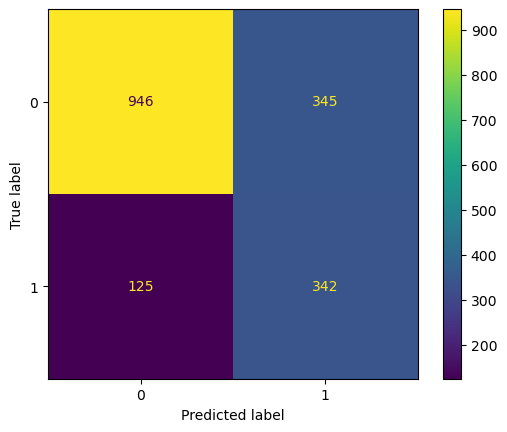

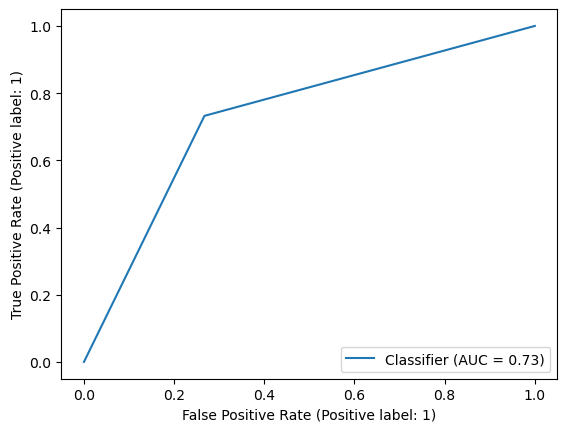

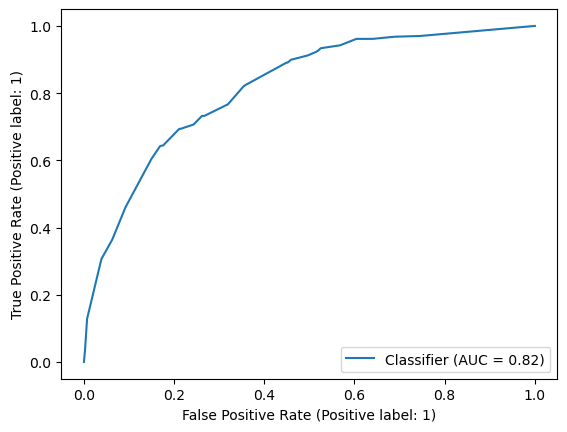

In [201]:
mentrics_eval(grid_tree, features_test, target_test,1,1,1,1)

использование парамера clss_weight: 'balanced', добавляет к метрике 0.05

модель в основном сильно ошибается с классом, которого мало, то есть с теми, кто расторгнул договор, даже при том, что весы были настроены

## Попробуем использовать стратификацию

In [220]:
tree_param = {
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_depth': range(5,20,2),
    'tree__min_samples_split': range(2,14,2),
    'tree__class_weight': ['balanced'],
}

In [221]:
skf = StratifiedKFold(5, shuffle=True, random_state=seed)
pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('tree', DecisionTreeClassifier(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=tree_param,
                    cv=skf,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [222]:
grid.fit(features_train, target_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=4; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=4; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=4; total time=   0.5s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tr

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=120922, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         (...
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines'])])),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=120922))]),
             n_jobs=-1,
             param_grid={'tree__class_weight': ['balanced'],
                         'tree__criterion': ['gini', 'entropy', 'log_loss'],
                         'tree__max_depth': range(5, 20, 2),
                         'tree__min_samples_split': range(2, 14, 2)},
             scoring='roc_auc', verbose=2)

In [223]:
grid.best_params_

{'tree__class_weight': 'balanced',
 'tree__criterion': 'gini',
 'tree__max_depth': 5,
 'tree__min_samples_split': 10}

Metrics:
roc_auc of predictions:       0.7433458783175235
accuracy_test of predictions: 0.7224118316268487


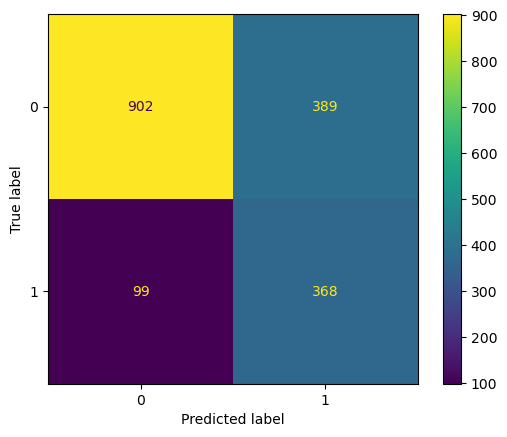

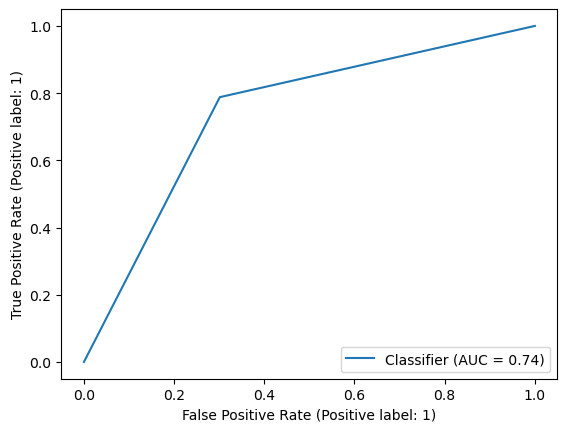

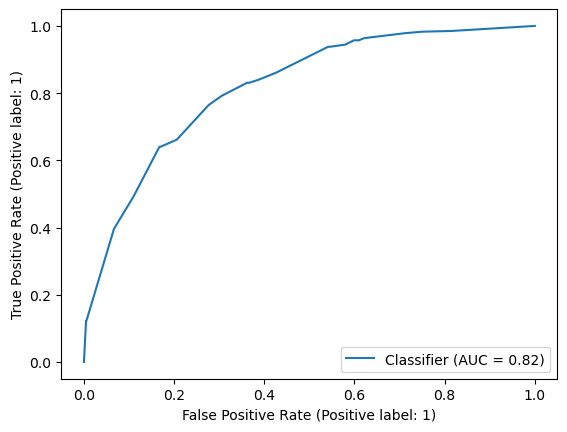

In [225]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

интересно, что стратифицированная кросс валидация, хоть и улучшает нахождение истино отрицательных вариантов, но ситуация с ложно положительными вариантами усугубляется

## Эксперимент оптимизации признаков

In [228]:
tree_param = {
    'tree__criterion': ['gini', 'entropy', 'log_loss'],
    'tree__max_depth': range(5,20,5),
    'tree__min_samples_split': range(2,14,2),
    'tree__class_weight': ['balanced'],
}

In [229]:
skf = StratifiedKFold(5, shuffle=True, random_state=seed)
pipeline = Pipeline(steps = [
                                    ('preprocessor', preprocessor),
                                    ('selector', GenericUnivariateSelect(score_func=mutual_info_classif, 
                                                                            mode='k_best', 
                                                                            param=6)),
                                    ('tree', DecisionTreeClassifier(random_state=seed)),
                                ])

grid = GridSearchCV(pipeline,
                        param_grid=tree_param,
                        cv=skf,
                        verbose=2,
                        n_jobs=-1,
                        scoring='roc_auc')
    
grid.fit(features_train, target_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   1.0s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   1.1s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   1.1s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=2; total time=   1.2s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=4; total time=   1.1s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=4; total time=   1.1s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tree__max_depth=5, tree__min_samples_split=4; total time=   1.1s
[CV] END tree__class_weight=balanced, tree__criterion=gini, tre

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=120922, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         (...
                                        GenericUnivariateSelect(mode='k_best',
                                                                param=6,
                                                                score_func=<function mutual_info_classif at 0x7f7b4e4090d0>)),
                                       ('tree',
                                        DecisionTreeClassifier(random_state=120922))]),
             n_jobs=-1,
             param_grid={'tree__class_weight': ['balanced'],
                         'tree__criterion': ['gini', 'entropy', 'log_loss'],
                         'tree__max_depth': range(5, 20, 5),
                         'tree__min_samples_split': range(2, 14, 2)},
             scoring='roc_auc', verbose=2)

Metrics:
roc_auc of predictions:       0.7305667468904307
accuracy_test of predictions: 0.7207053469852105


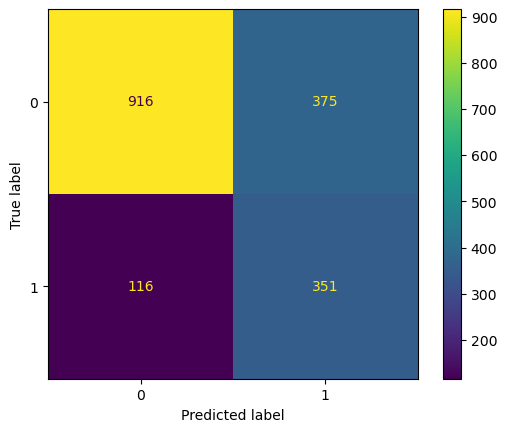

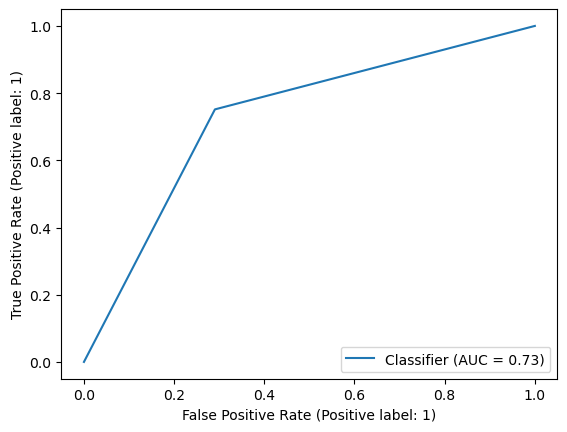

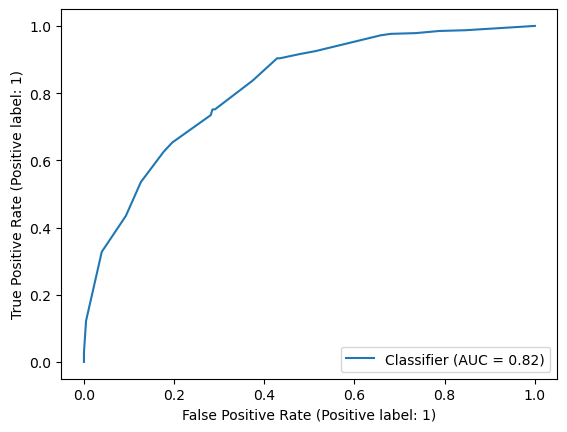

In [230]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

значительно ничего не изменилось

слегка улучшилась ситуация с истынными, но ситуация с ложными ухудшилась относительно варианта с стратификацией

# Форест

## Простая проверка

In [231]:
pipeline = Pipeline(steps = [
               ('preprocessor', preprocessor)
              ,('classificator',RandomForestClassifier())
           ])

In [232]:
tree_results = cross_val_score(pipeline, features_train, target_train, cv=10, scoring='roc_auc', verbose=1)
tree_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.2s finished


array([0.81170839, 0.82071981, 0.84179999, 0.84999175, 0.82122554,
       0.80692137, 0.81637135, 0.82011812, 0.84011628, 0.78152455])

## Подбираем параметры

In [233]:
forest_param = {
    'forest__criterion': ['gini'],
    'forest__n_estimators': range(100,500,50),
    'forest__max_depth': range(2,20,2),
    'forest__class_weight': ['balanced'],
}

In [234]:
pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('forest', RandomForestClassifier(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=forest_param,
                    cv=5,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [235]:
grid.fit(features_train, target_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=150; total time=   0.9s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=150; total time=   0.9s
[CV] END forest__class_weigh

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('KNN',
                                                                                          KNNImputer())]),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMe...
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines'])])),
                                       ('forest',
                                        RandomForestClassifier(random_state=120922))]),
             n_jobs=-1,
             param_grid={'forest__class_weight': ['balanced'],
                         'forest__criterion': ['gini'],
                         'forest__max_depth': range(2, 20, 2),
                         'forest__n_estimators': range(100, 500, 50)},
             scoring='roc_auc', verbose=2)

In [236]:
grid.best_params_

{'forest__class_weight': 'balanced',
 'forest__criterion': 'gini',
 'forest__max_depth': 8,
 'forest__n_estimators': 150}

Metrics:
roc_auc of predictions:       0.7578359155875714
accuracy_test of predictions: 0.7497155858930603


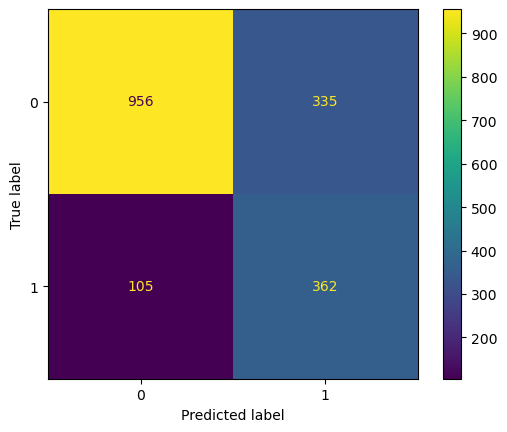

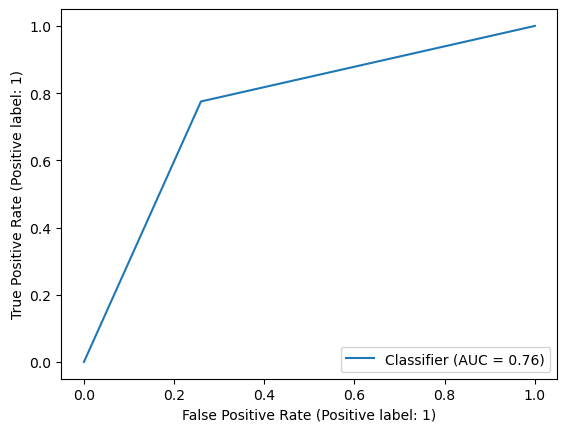

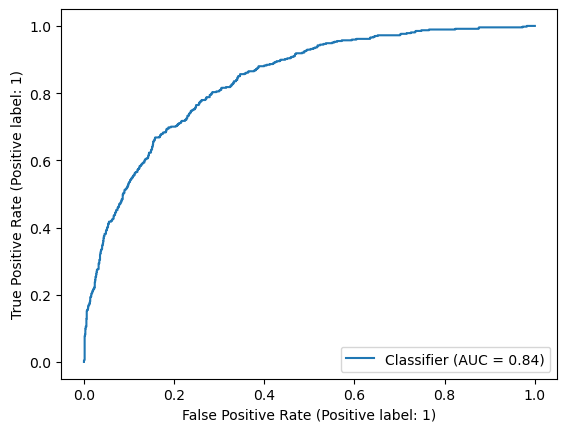

In [237]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

лес чуть больше разделяет истино отрицательные случаи, но с остальными вариантами ситуация сильно не меняется

## Стратификация

In [238]:
forest_param = {
    'forest__criterion': ['gini'],
    'forest__n_estimators': range(100,500,50),
    'forest__max_depth': range(2,20,2),
    'forest__class_weight': ['balanced'],
}

In [239]:
skf = StratifiedKFold(5, shuffle=True, random_state=seed)
pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('forest', RandomForestClassifier(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=forest_param,
                    cv=skf,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [240]:
grid.fit(features_train, target_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.7s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=100; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=150; total time=   0.8s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__n_estimators=150; total time=   0.9s
[CV] END forest__class_weigh

In [241]:
grid.best_score_

0.846805178128967

In [242]:
grid.best_params_

{'forest__class_weight': 'balanced',
 'forest__criterion': 'gini',
 'forest__max_depth': 8,
 'forest__n_estimators': 400}

Metrics:
roc_auc of predictions:       0.7601820874875809
accuracy_test of predictions: 0.7491467576791809


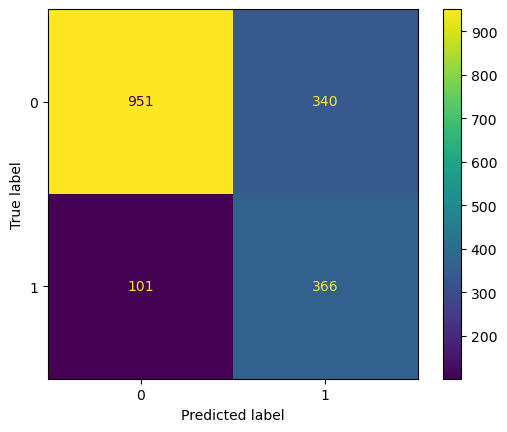

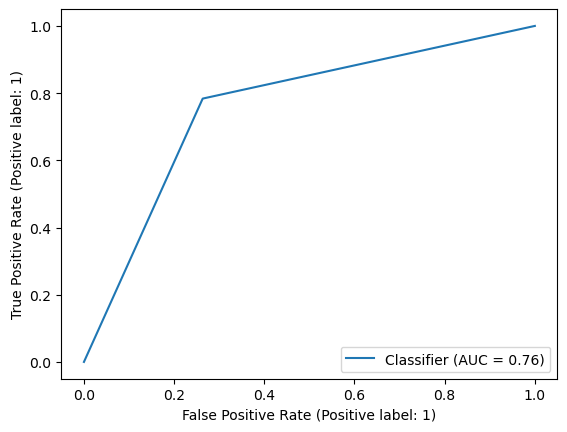

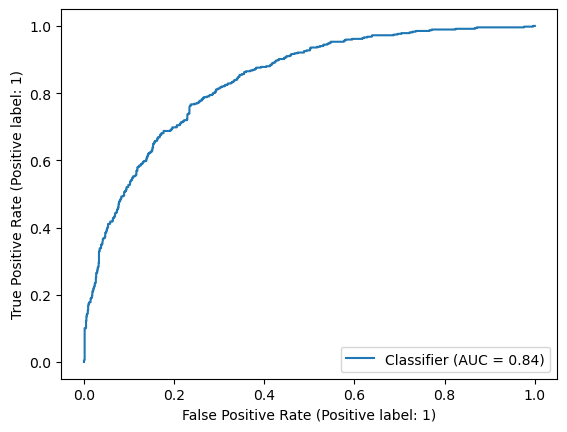

In [243]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

так же не много изменилось в метрике и ситуации

## Тест оптимизации признаков

In [244]:
forest_param = {
    'forest__criterion': ['gini', 'entropy', 'log_loss'],
    'forest__n_estimators': range(100,301,50),
    'forest__max_depth': range(2,15,2),
    'forest__min_samples_split': range(2,7,2),
    'forest__class_weight': ['balanced'],
}

In [245]:
skf = StratifiedKFold(5, shuffle=True, random_state=seed)
pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('selector', GenericUnivariateSelect(score_func=mutual_info_classif, 
                                                                        mode='k_best', 
                                                                        param=6)),
                                ('forest', RandomForestClassifier(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=forest_param,
                    cv=skf,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [246]:
grid.fit(features_train, target_train)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__min_samples_split=2, forest__n_estimators=100; total time=   1.3s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__min_samples_split=2, forest__n_estimators=100; total time=   1.3s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__min_samples_split=2, forest__n_estimators=100; total time=   1.3s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__min_samples_split=2, forest__n_estimators=100; total time=   1.3s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__min_samples_split=2, forest__n_estimators=100; total time=   1.3s
[CV] END forest__class_weight=balanced, forest__criterion=gini, forest__max_depth=2, forest__min_samples_split=2, forest__n_estimators=150; t

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=120922, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         (...
                                                                score_func=<function mutual_info_classif at 0x7f7b4e4090d0>)),
                                       ('forest',
                                        RandomForestClassifier(random_state=120922))]),
             n_jobs=-1,
             param_grid={'forest__class_weight': ['balanced'],
                         'forest__criterion': ['gini', 'entropy', 'log_loss'],
                         'forest__max_depth': range(2, 15, 2),
                         'forest__min_samples_split': range(2, 7, 2),
                         'forest__n_estimators': range(100, 301, 50)},
             scoring='roc_auc', verbose=2)

In [247]:
grid.best_params_

{'forest__class_weight': 'balanced',
 'forest__criterion': 'log_loss',
 'forest__max_depth': 6,
 'forest__min_samples_split': 4,
 'forest__n_estimators': 150}

Metrics:
roc_auc of predictions:       0.7523225360219076
accuracy_test of predictions: 0.7406143344709898


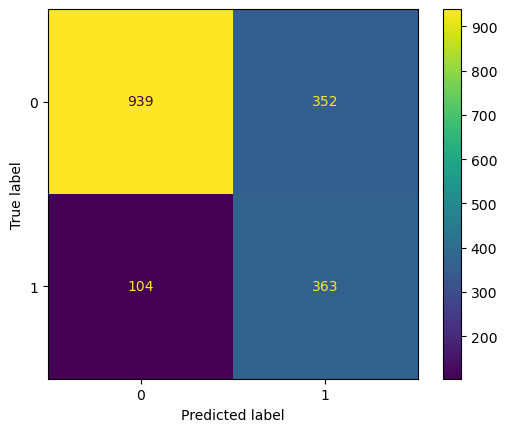

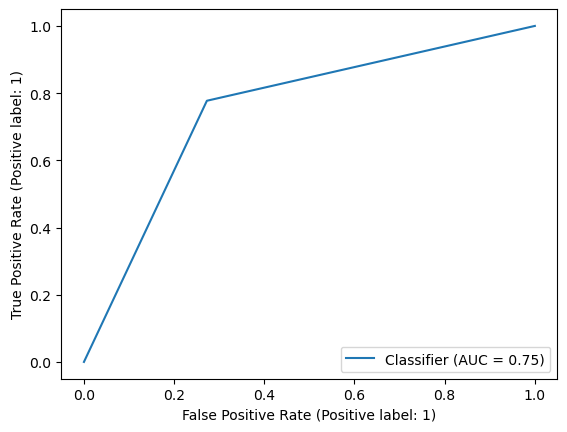

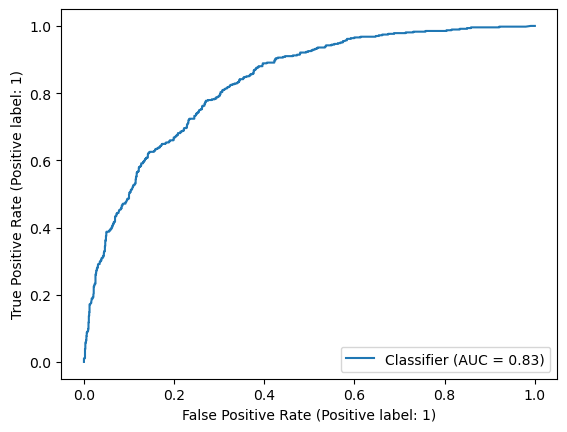

In [248]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

уменьшения количества признаков и выбор только наиболее значимых не привел к значимому улучшению метрики.

# Логистическая классификация

## Простая проверка

In [224]:
pipeline = Pipeline(steps = [
                     ('preprocessor', preprocessor),
                     ('logistic', LogisticRegression(random_state=seed))
           ])

In [225]:
logistic_results = cross_val_score(pipeline, features_train, target_train, cv=10, scoring='roc_auc', verbose=1)
logistic_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished


array([0.81756373, 0.81971649, 0.82991532, 0.83352356, 0.824677  ,
       0.83920266, 0.82275748, 0.7977667 , 0.8284976 , 0.82720561])

## Подбираем параметры

In [424]:
log_param = {
    'logistic__C': np.arange(0.1,1.1,0.1),
    'logistic__class_weight': ['balanced'],
    'logistic__solver': ['liblinear'],
}

In [425]:
pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('logistic', LogisticRegression(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=log_param,
                    cv=10,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [426]:
grid.fit(features_train, target_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; to

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),
                                                                                         ('KNN',
                                                                                          KNNImputer())]),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentM...
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines'])])),
                                       ('logistic',
                                        LogisticRegression(random_state=120922))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logistic__class_weight': ['balanced'],
                         'logistic__solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

In [427]:
grid.best_params_

{'logistic__C': 1.0,
 'logistic__class_weight': 'balanced',
 'logistic__solver': 'liblinear'}

In [428]:
grid.classes_

array([0, 1])

Metrics:
roc_auc of predictions:       0.7453288040909144
accuracy_test of predictions: 0.7343572241183163


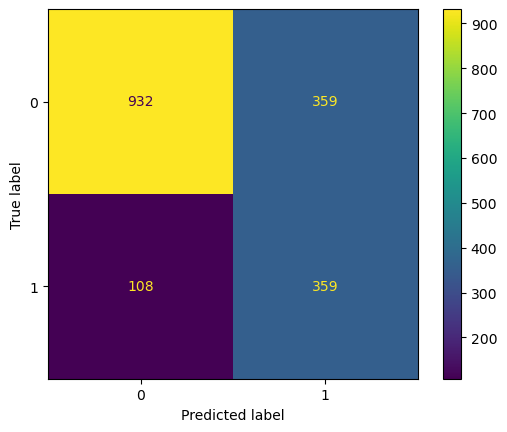

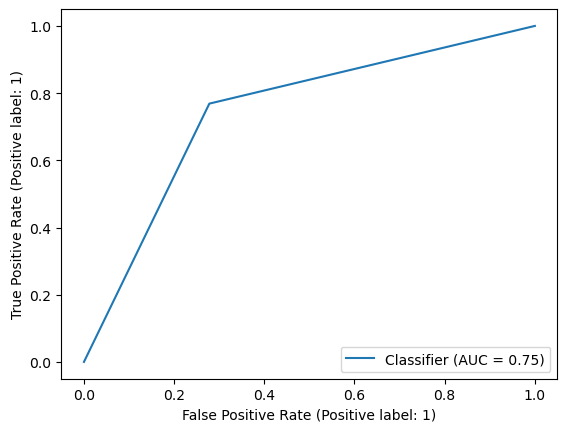

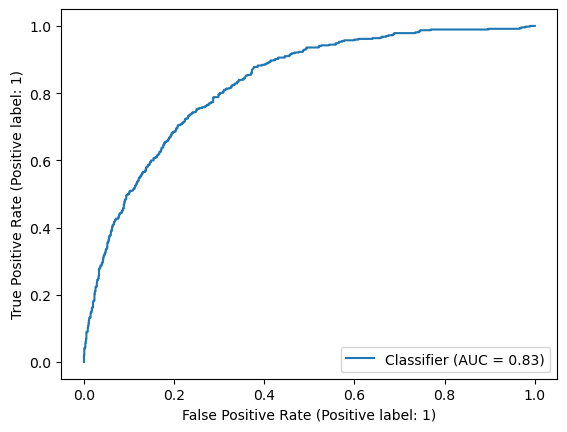

In [429]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

из за того, что в логистической регрессии не были настроены весы для классов, то уровень срабатывания не совсем оптимальный
но даннай картина позволяет нам предположить, что скорее всего при использовании нескольких логистических регрессий, которые мы в последующем соединим, может привести к увеличению метрики

## Стратификация

In [430]:
skf = StratifiedKFold(10, shuffle=True, random_state=seed)
pipeline = Pipeline(steps = [
                                ('preprocessor', preprocessor),
                                ('logistic', LogisticRegression(random_state=seed)),
                            ])

grid = GridSearchCV(pipeline,
                    param_grid=log_param,
                    cv=skf,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [431]:
grid.fit(features_train, target_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.0s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; to

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=120922, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),...
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines'])])),
                                       ('logistic',
                                        LogisticRegression(random_state=120922))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logistic__class_weight': ['balanced'],
                         'logistic__solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

In [432]:
grid.best_params_

{'logistic__C': 0.8,
 'logistic__class_weight': 'balanced',
 'logistic__solver': 'liblinear'}

Metrics:
roc_auc of predictions:       0.7453288040909144
accuracy_test of predictions: 0.7343572241183163


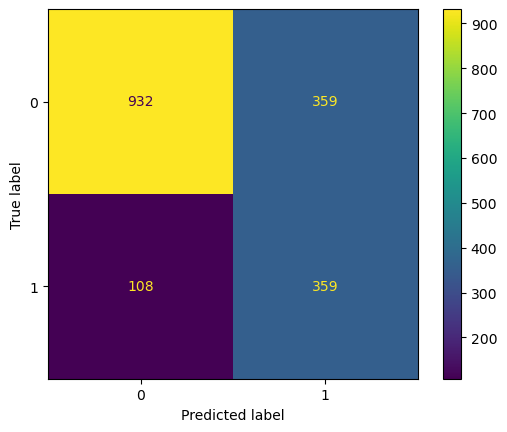

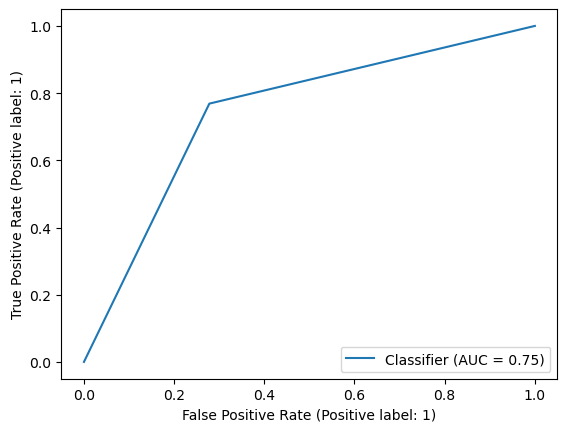

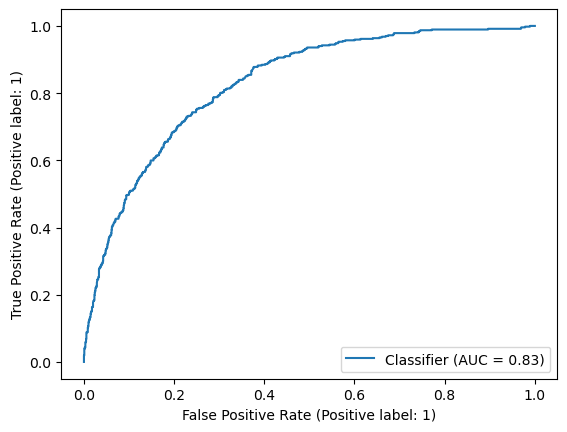

In [433]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

## Тест оптимизации признаков

In [434]:
skf = StratifiedKFold(10, shuffle=True, random_state=seed)
pipeline = Pipeline(steps = [
                                    ('preprocessor', preprocessor),
                                    ('selector', GenericUnivariateSelect(score_func=mutual_info_classif, 
                                                                            mode='k_best', 
                                                                            param=6)),
                                    ('logistic', LogisticRegression(random_state=seed)),
                                ])

grid = GridSearchCV(pipeline,
                        param_grid=log_param,
                        cv=skf,
                        verbose=2,
                        n_jobs=-1,
                        scoring='roc_auc')
grid.fit(features_train, target_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.4s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.5s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.5s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.5s
[CV] END logistic__C=0.2, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.4s
[CV] END logistic__C=0.2, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.5s
[CV] END logistic__C=0.2, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.4s
[CV] END logistic__C=0.1, logistic__class_weight=balanced, logistic__solver=liblinear; total time=   0.5s
[CV] END logistic__C=0.2, logistic__class_weight=balanced, logistic__solver=liblinear; to

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=120922, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('minmax',
                                                                                          MinMaxScaler())]),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges']),
                                                                        ('categorical',
                                                                         Pipeline(steps=[('encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse=False)),...
                                       ('selector',
                                        GenericUnivariateSelect(mode='k_best',
                                                                param=6,
                                                                score_func=<function mutual_info_classif at 0x7f7b4e4090d0>)),
                                       ('logistic',
                                        LogisticRegression(random_state=120922))]),
             n_jobs=-1,
             param_grid={'logistic__C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
                         'logistic__class_weight': ['balanced'],
                         'logistic__solver': ['liblinear']},
             scoring='roc_auc', verbose=2)

Metrics:
roc_auc of predictions:       0.7415006211674631
accuracy_test of predictions: 0.7207053469852105


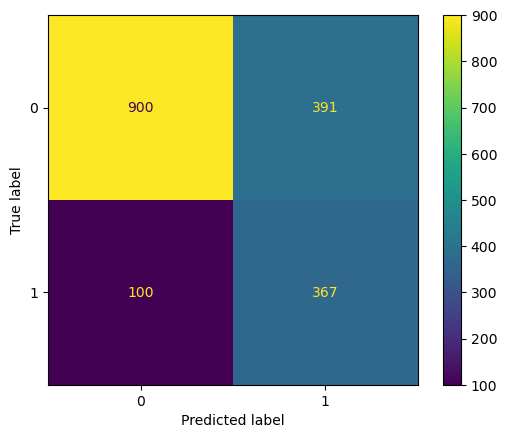

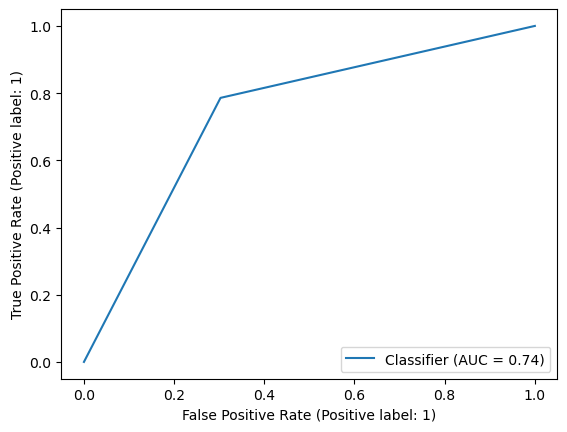

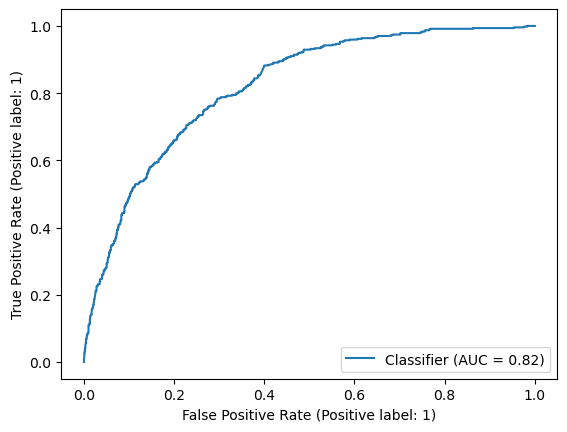

In [435]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)


# manual KNN

## Подготовка данных

In [58]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalCharges'] = df['TotalCharges'].astype('float')
/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['EndDate'], inplace=True)
/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[train.notnull()] = np.sq

## Catboost

In [59]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))


        roc_auc of predictions:       0.76585386890298
        accuracy_test of predictions: 0.7474402730375427


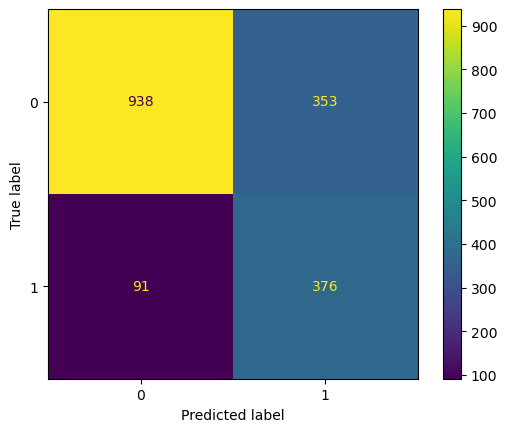

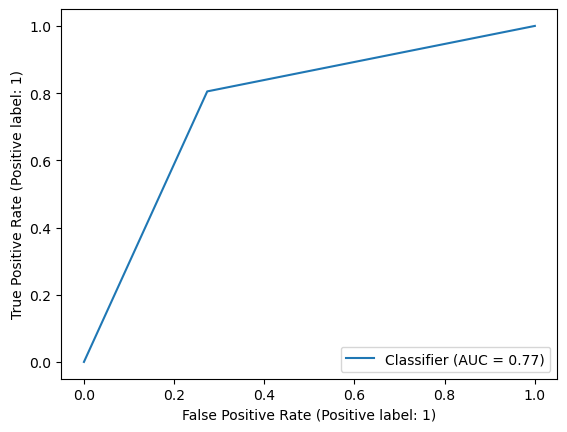

In [60]:
# первичный тест CatBoost
CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False,
        # plot=True
    )
    # make the prediction using the resulting model
mentrics_eval(CatBC, features_test, target_test,1,1,1,1)


### Эксперимент с алгоритмами апсемплинга

алгоритмы создают синтетические данные на основе расстояния до ближайших

#### AllKNN

In [68]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN()

In [69]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [70]:
features_train, target_train = allknn.fit_resample(features_train, target_train)


        roc_auc of predictions:       0.7525912386361185
        accuracy_test of predictions: 0.6928327645051194


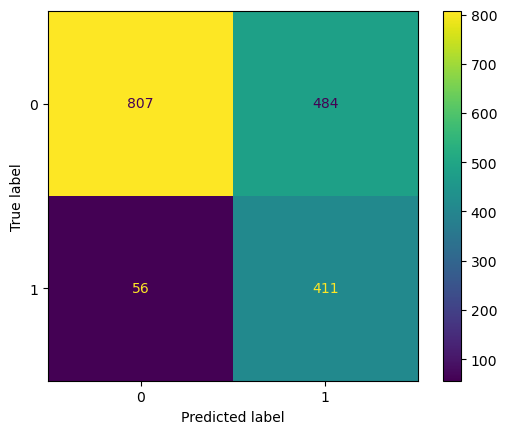

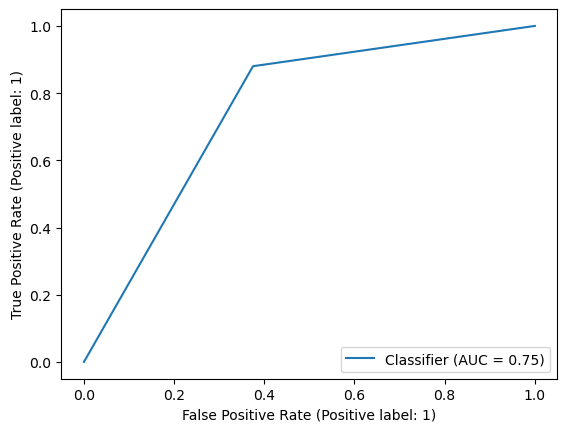

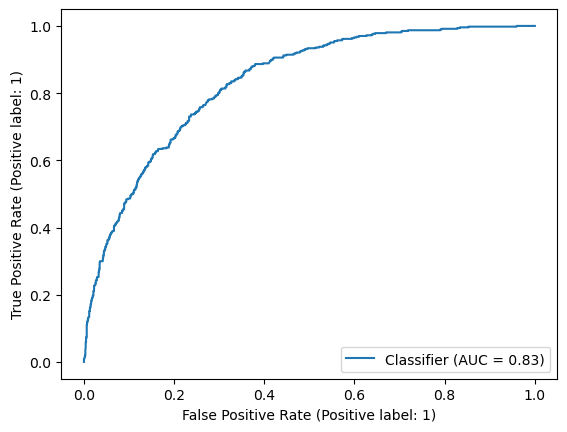

In [71]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False,
        # plot=True
    )
    # make the prediction using the resulting model

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)


#### SMOTE

In [72]:
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE

In [73]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [74]:
sm = SMOTE(random_state=seed)

In [75]:
features_train, target_train = sm.fit_resample(features_train, target_train)


        roc_auc of predictions:       0.7556498041954098
        accuracy_test of predictions: 0.7565415244596132


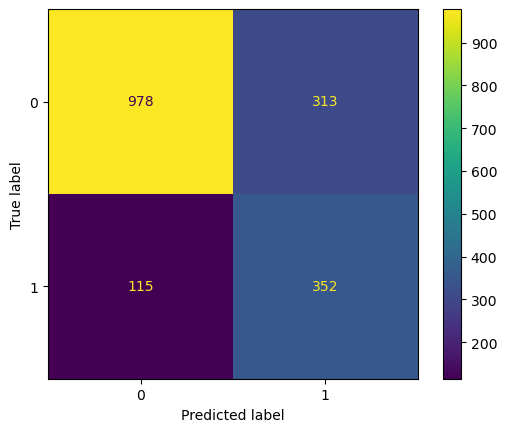

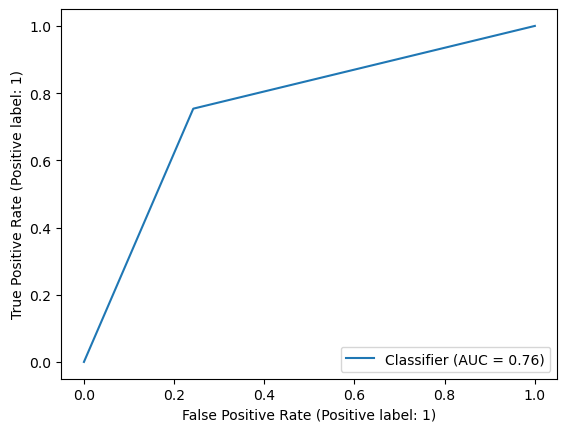

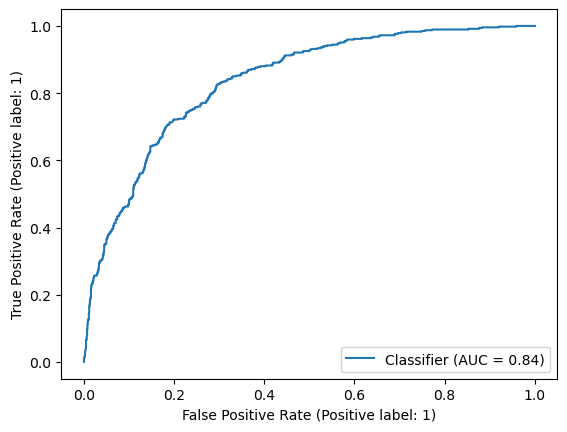

In [76]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False,
        # plot=True
    )
    # make the prediction using the resulting model

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)


#### SVMSMOTE

In [363]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [364]:
svms = SVMSMOTE(random_state=seed)

In [365]:
features_train, target_train = svms.fit_resample(features_train, target_train)

##### CatBoost


        roc_auc of predictions:       0.7542142355991157
        accuracy_test of predictions: 0.7514220705346986


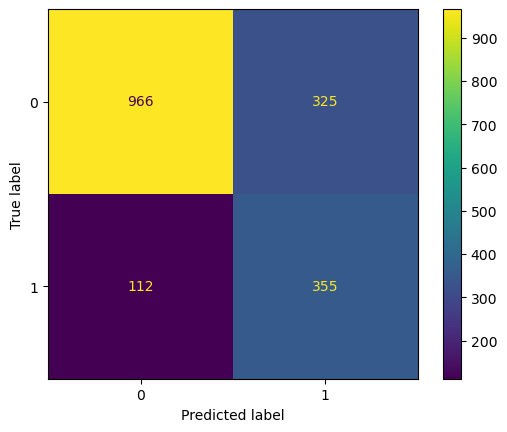

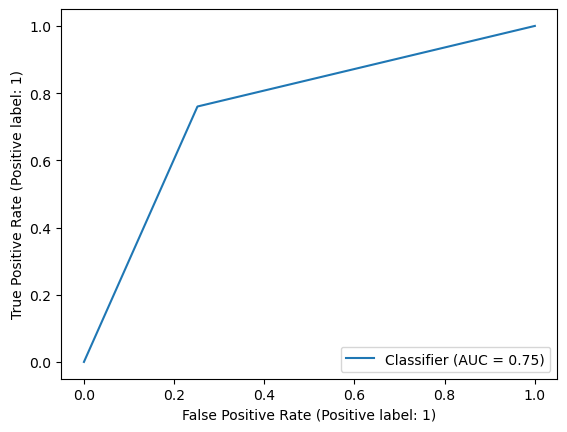

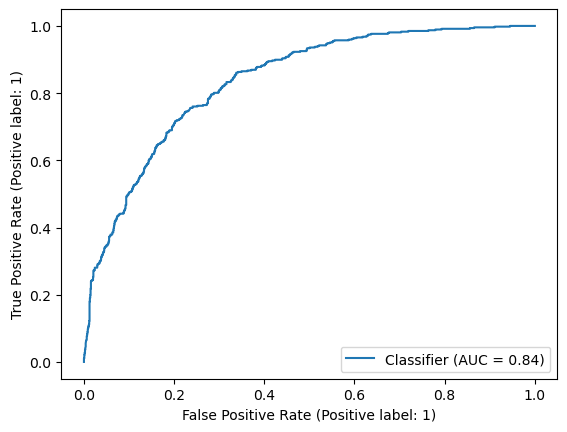

In [80]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False,
        # plot=True
    )
    # make the prediction using the resulting model

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)


##### Тест нейронной сети

In [ ]:
params = {
    'hidden_layer_sizes': range(3,1000,50)
}

clf = MLPClassifier(hidden_layer_sizes=10, early_stopping=True, random_state=seed)

grid = GridSearchCV(clf,
                    param_grid=params,
                    cv=5,
                    verbose=2,
                    n_jobs=-1,
                    scoring='roc_auc')

In [ ]:
grid.fit(features_train.values, target_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
[CV] END ...............................hidden_layer_sizes=7; total time=   0.3s
[CV] END ...............................hidden_layer_sizes=3; total time=   0.6s
[CV] END ...............................hidden_layer_sizes=7; total time=   0.4s
[CV] END ..............................hidden_layer_sizes=11; total time=   0.4s
[CV] END ..............................hidden_layer_sizes=11; total time=   0.4s
[CV] END ...............................hidden_layer_sizes=3; total time=   0.7s
[CV] END ...............................hidden_layer_sizes=3; total time=   0.7s
[CV] END ...............................hidden_layer_sizes=3; total time=   0.5s
[CV] END ..............................hidden_layer_sizes=11; total time=   0.4s
[CV] END ...............................hidden_layer_sizes=3; total time=   0.9s
[CV] END ..............................hidden_layer_sizes=15; total time=   0.5s
[CV] END ..............................hidden

GridSearchCV(cv=5,
             estimator=MLPClassifier(early_stopping=True, hidden_layer_sizes=10,
                                     random_state=120922),
             n_jobs=-1, param_grid={'hidden_layer_sizes': range(3, 1000, 4)},
             scoring='roc_auc', verbose=2)

In [ ]:
grid.best_score_

0.861669264430664

In [ ]:
grid.best_params_

{'hidden_layer_sizes': 899}

Metrics:
roc_auc of predictions:       0.7343037036176993
accuracy_test of predictions: 0.7332195676905574


/home/qq/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names

/home/qq/miniconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but MLPClassifier was fitted without feature names



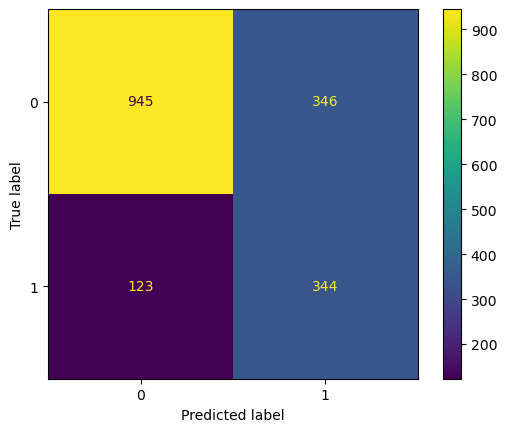

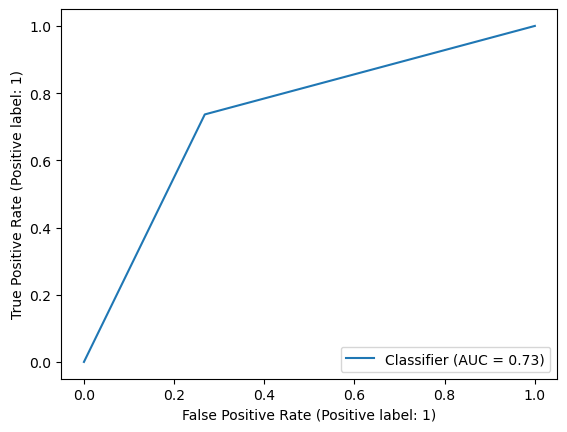

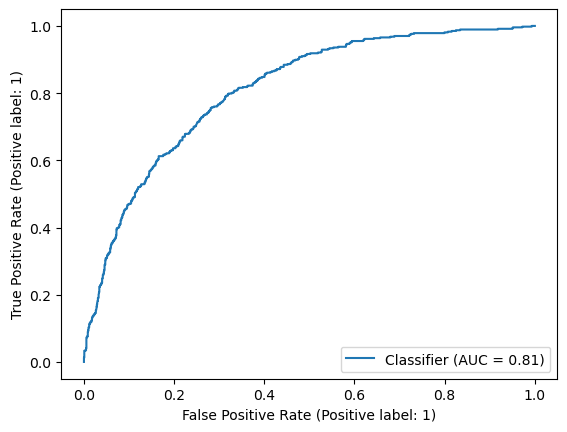

In [ ]:
mentrics_eval(grid.best_estimator_, features_test, target_test,1,1,1,1)

#### ADASYN

In [89]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [90]:
ad = ADASYN(random_state=seed)

In [91]:
features_train, target_train = ad.fit_resample(features_train, target_train)


        roc_auc of predictions:       0.7532812404108828
        accuracy_test of predictions: 0.7610921501706485


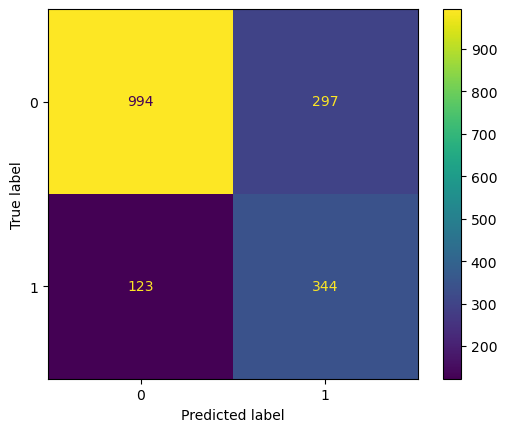

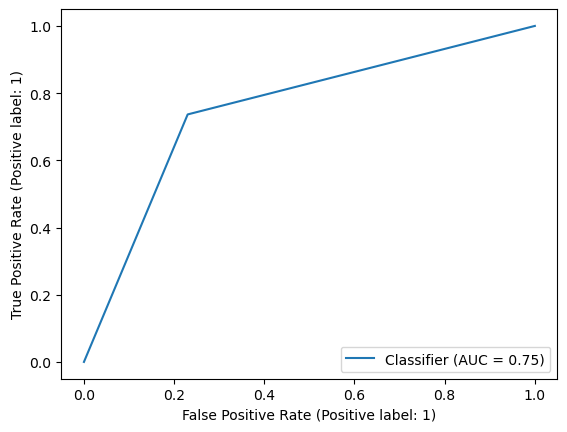

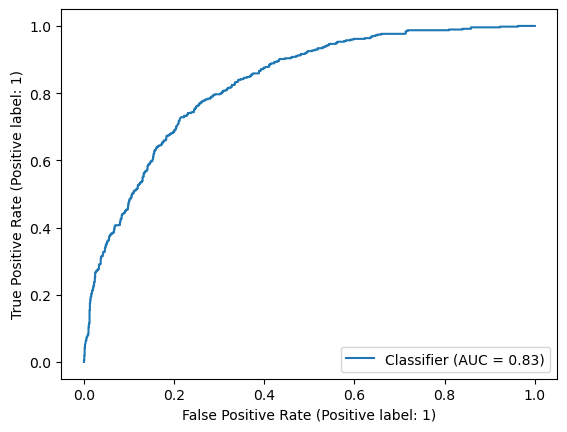

In [94]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        # auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False,
        # plot=True
    )
    # make the prediction using the resulting model

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)


### Эксперимент с SMOTETomek

In [ ]:
from imblearn.combine import SMOTETomek

In [165]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [164]:
st = SMOTETomek()

In [166]:
features_train, target_train = st.fit_resample(features_train, target_train)

Metrics:
roc_auc of predictions:       0.755217723757126
accuracy_test of predictions: 0.7639362912400455


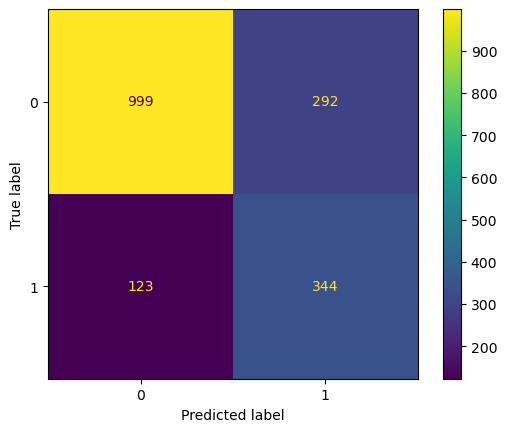

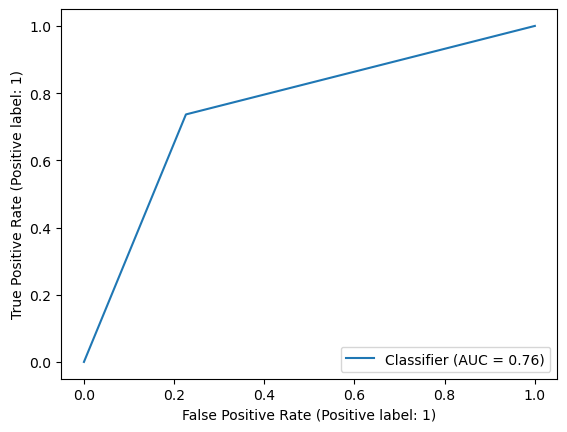

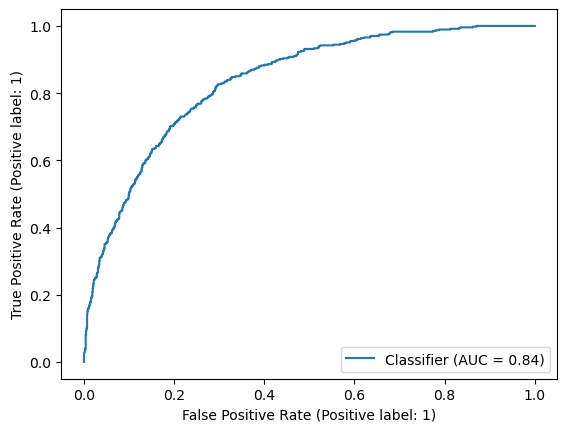

In [169]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        # auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False,
        # plot=True
    )
    # make the prediction using the resulting model

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.024146
Step #1 out of 1
0:	learn: 0.6796778	total: 7.62ms	remaining: 7.61s
1:	learn: 0.6673313	total: 15.3ms	remaining: 7.61s
2:	learn: 0.6540404	total: 26.3ms	remaining: 8.74s
3:	learn: 0.6433673	total: 35ms	remaining: 8.71s
4:	learn: 0.6335932	total: 43.7ms	remaining: 8.69s
5:	learn: 0.6229169	total: 57ms	remaining: 9.44s
6:	learn: 0.6136334	total: 69.7ms	remaining: 9.88s
7:	learn: 0.6051598	total: 77.1ms	remaining: 9.55s
8:	learn: 0.5957965	total: 83.8ms	remaining: 9.22s
9:	learn: 0.5881355	total: 90.9ms	remaining: 9s
10:	learn: 0.5810793	total: 101ms	remaining: 9.04s
11:	learn: 0.5745801	total: 109ms	remaining: 8.96s
12:	learn: 0.5677256	total: 116ms	remaining: 8.78s
13:	learn: 0.5641033	total: 118ms	remaining: 8.33s
14:	learn: 0.5583006	total: 125ms	remaining: 8.21s
15:	learn: 0.5544789	total: 130ms	remaining: 8s
16:	learn: 0.5479088	total: 137ms	remaining: 7.89s
17:	learn: 0.5437450	total: 143ms	remaining: 7.81s
18:	learn: 0.5392630	total: 150ms	remaining: 

Metrics:
roc_auc of predictions:       0.7557186385070749
accuracy_test of predictions: 0.7616609783845278


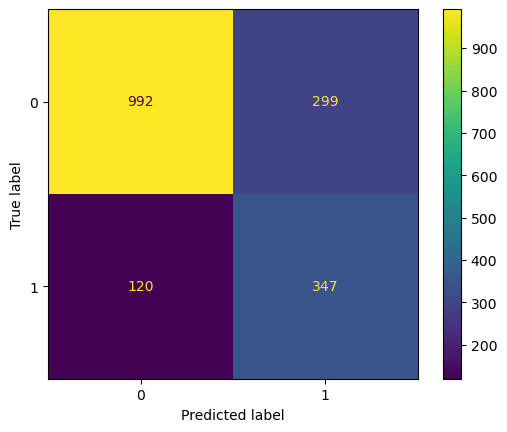

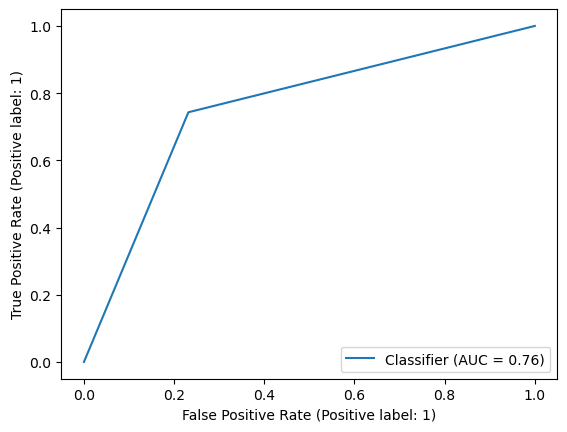

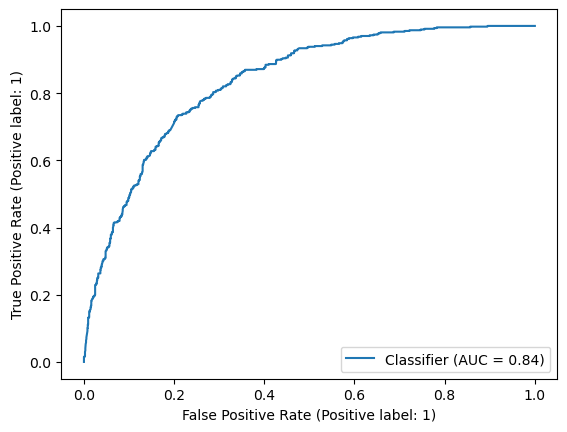

In [168]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        # auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.select_features(
                train_pool,
                features_for_select=list(features_train.columns),
                num_features_to_select=6,
                algorithm='RecursiveByShapValues',
                train_final_model=True,
                plot=True)

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)

### Эксперимент выбора признаков

In [85]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.024668
Step #1 out of 1
0:	learn: 0.6840203	total: 14.5ms	remaining: 14.5s
1:	learn: 0.6757607	total: 25.7ms	remaining: 12.8s
2:	learn: 0.6670211	total: 44.6ms	remaining: 14.8s
3:	learn: 0.6581399	total: 84.8ms	remaining: 21.1s
4:	learn: 0.6512696	total: 93.5ms	remaining: 18.6s
5:	learn: 0.6432322	total: 107ms	remaining: 17.8s
6:	learn: 0.6360968	total: 117ms	remaining: 16.6s
7:	learn: 0.6292342	total: 127ms	remaining: 15.7s
8:	learn: 0.6229375	total: 135ms	remaining: 14.9s
9:	learn: 0.6165123	total: 144ms	remaining: 14.2s
10:	learn: 0.6113046	total: 153ms	remaining: 13.7s
11:	learn: 0.6068316	total: 160ms	remaining: 13.2s
12:	learn: 0.6016977	total: 170ms	remaining: 12.9s
13:	learn: 0.5971625	total: 180ms	remaining: 12.7s
14:	learn: 0.5921484	total: 192ms	remaining: 12.6s
15:	learn: 0.5883623	total: 204ms	remaining: 12.5s
16:	learn: 0.5840447	total: 212ms	remaining: 12.3s
17:	learn: 0.5804973	total: 224ms	remaining: 12.2s
18:	learn: 0.5775129	total: 231ms	remain


        roc_auc of predictions:       0.745716100760163
        accuracy_test of predictions: 0.7349260523321957


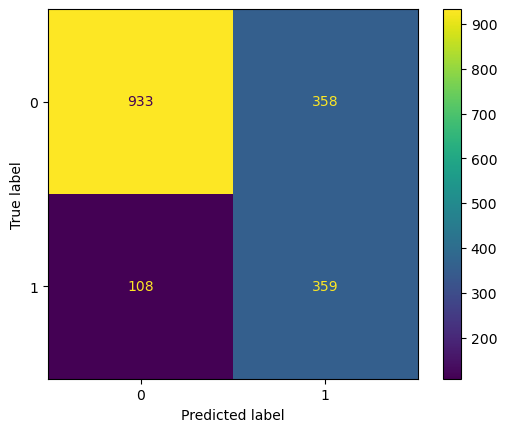

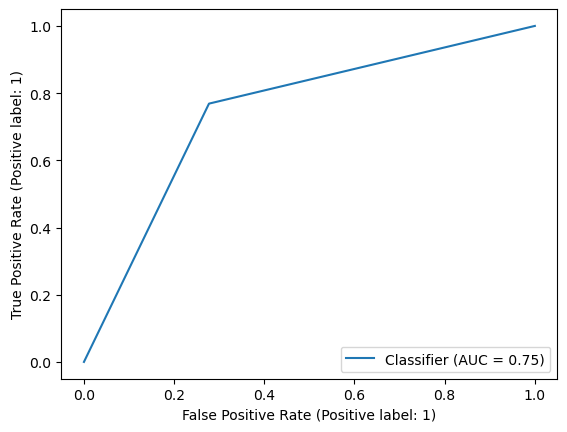

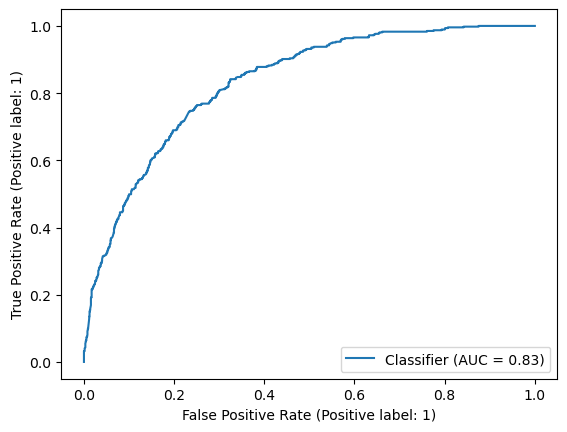

In [100]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        # auto_class_weights="Balanced",
        boosting_type="Ordered",
        random_state=seed
    )

CatBC.select_features(
                train_pool,
                features_for_select=list(features_train.columns),
                num_features_to_select=6,
                algorithm='RecursiveByShapValues',
                train_final_model=True,
                plot=True)

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)

### Поиск весов

In [101]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [102]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

In [103]:
weights = np.linspace(0.0,0.99,200)
auc_final = []

In [104]:
for i in weights:
    CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        class_weights=[1-i, i],
        boosting_type="Ordered",
        random_state=seed
    )

    CatBC.fit(
        train_pool,
        verbose=False
    )

    cat_preds = CatBC.predict(test_pool)
    auc_final.append(roc_auc_score(target_test, cat_preds))

0.7705686045875166


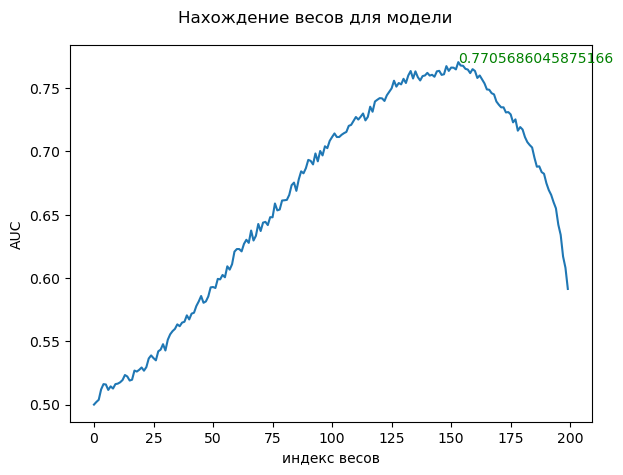

In [105]:
i = pd.Series(auc_final)
best = np.array(auc_final).argmax()
print(auc_final[best])

x = i.index
y = i

# plot
fig, ax = plt.subplots()

ax.plot(x, y)

plt.text(best, auc_final[best], auc_final[best], color='g')

fig.suptitle('Нахождение весов для модели')
plt.ylabel('AUC')
plt.xlabel('индекс весов')
fig.tight_layout()
plt.show()


        roc_auc of predictions:       0.7660346626372333
        accuracy_test of predictions: 0.732650739476678


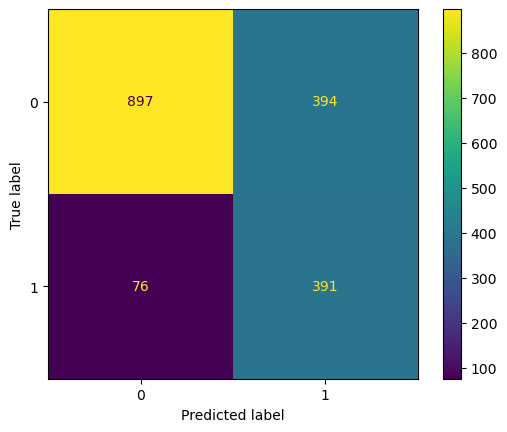

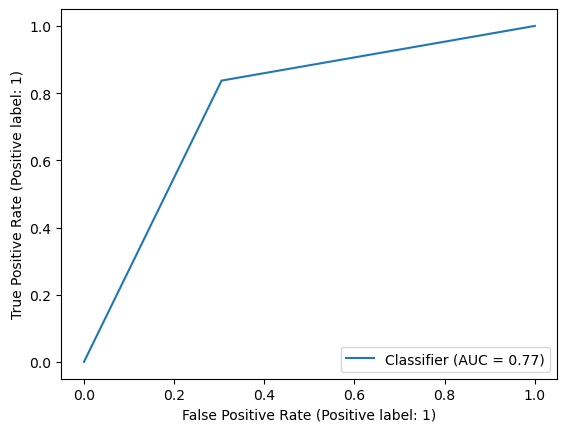

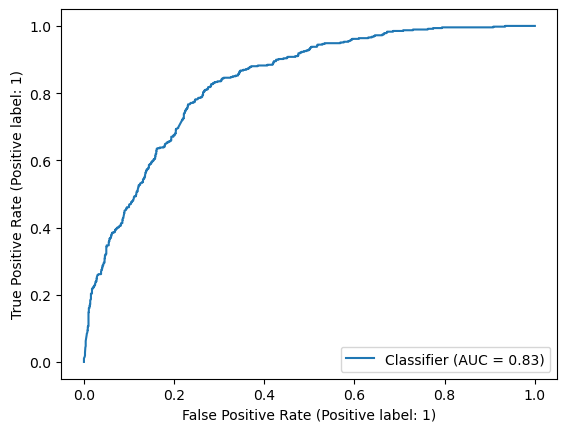

In [107]:
weight1 = 0.7705686045875166

# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        class_weights=[1-weight1, weight1],
        boosting_type="Ordered",
        ignored_features=[8, 14, 15, 12, 7, 9, 13, 11, 6, 16, 1],
        random_state=seed
    )

CatBC.fit(
        train_pool,
        verbose=False
    )
    # make the prediction using the resulting model

mentrics_eval(CatBC, features_test, target_test,1,1,1,1)

#### Поиск весов при использовании алгоритма апсемплинга SVMSMOTE

In [108]:
features_train, features_test, target_train, target_test = manual_knn((df_contract, df_internet, df_personal, df_phone,), 
                                                                        categorical_features, 
                                                                        numeric_features,)

/tmp/ipykernel_4719/2934735090.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/2934735090.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_4719/545646823.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See

In [109]:
svms = SVMSMOTE(random_state=seed)
features_train, target_train = svms.fit_resample(features_train, target_train)

In [110]:
# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

In [111]:
weights = np.linspace(0.0,0.99,200)
auc_final = []

In [112]:
for i in weights:
    CatBC = CatBoostClassifier(
        early_stopping_rounds=5,
        class_weights=[1-i, i],
        random_state=seed
    )

    CatBC.fit(
        train_pool,
        verbose=False
    )
    # make the prediction using the resulting model
    cat_preds = CatBC.predict(test_pool)
    auc_final.append(roc_auc_score(target_test, cat_preds))

0.7625523099302203


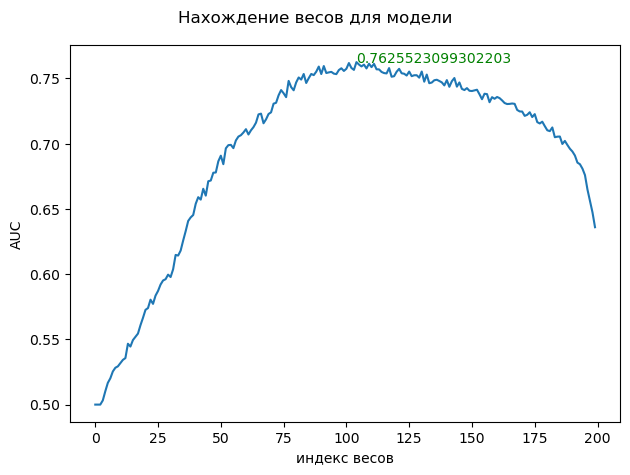

In [113]:
i = pd.Series(auc_final)
best = np.array(auc_final).argmax()
print(auc_final[best])

x = i.index
y = i

# plot
fig, ax = plt.subplots()

ax.plot(x, y)

plt.text(best, auc_final[best], auc_final[best], color='g')

fig.suptitle('Нахождение весов для модели')
plt.ylabel('AUC')
plt.xlabel('индекс весов')
fig.tight_layout()
plt.show()


        roc_auc of predictions:       0.7389686795588633
        accuracy_test of predictions: 0.6848691695108078


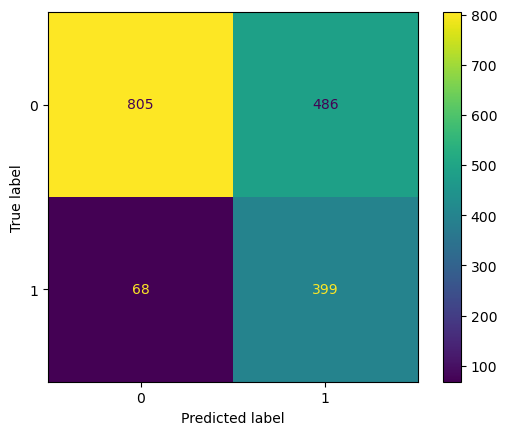

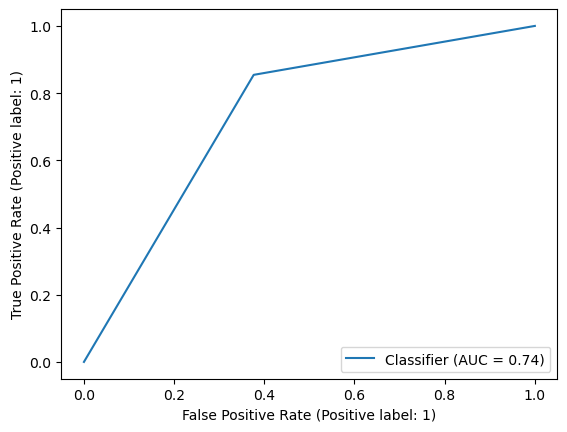

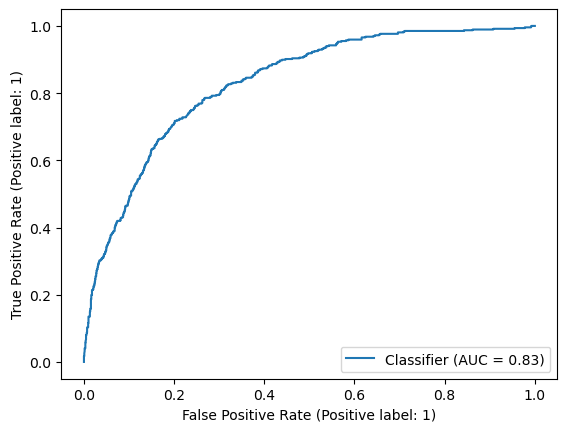

In [114]:
# если используем алгоритм SVMSMOTE
# то вот идеальные весы для него с масимальным возможным AUC
weight1 = auc_final[best]

# initialize Pool
train_pool = Pool(features_train, 
                  target_train, cat_features=categorical_features, feature_names=list(features_train.columns))
test_pool = Pool(features_test, cat_features=categorical_features, feature_names=list(features_test.columns))

CatBC = CatBoostClassifier(
    early_stopping_rounds=5,
    class_weights=[1-weight1, weight1],
    random_state=seed
)

CatBC.fit(
    train_pool,
    verbose=False
)

# make the prediction using the resulting model
mentrics_eval(CatBC, features_test, target_test,1,1,1,1)

## Optuna Forest optimisation


In [286]:
def objective(trial):

    rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy', 'log_loss'])
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 1000, log=True)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 20, log=True)
    rf_class_weight = trial.suggest_categorical("rf_class_weight", ['balanced', 'balanced_subsample'])
    
    classifier_obj = RandomForestClassifier(
        criterion=rf_criterion, max_depth=rf_max_depth, n_estimators=rf_n_estimators, class_weight=rf_class_weight
    )

    score = cross_val_score(classifier_obj, features_train, target_train, n_jobs=-1, scoring='roc_auc', cv=5)
    accuracy = score.mean()
    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)
    print(study.best_trial)

[I 2022-09-15 13:01:08,148] A new study created in memory with name: no-name-b9277104-12be-49f7-a294-381f9406f679
[I 2022-09-15 13:01:10,185] Trial 0 finished with value: 0.8348964949249961 and parameters: {'rf_criterion': 'gini', 'rf_n_estimators': 443, 'rf_max_depth': 2, 'rf_class_weight': 'balanced'}. Best is trial 0 with value: 0.8348964949249961.
[I 2022-09-15 13:01:12,052] Trial 1 finished with value: 0.9418211938056107 and parameters: {'rf_criterion': 'entropy', 'rf_n_estimators': 382, 'rf_max_depth': 12, 'rf_class_weight': 'balanced'}. Best is trial 1 with value: 0.9418211938056107.
[I 2022-09-15 13:01:13,464] Trial 2 finished with value: 0.858272030592485 and parameters: {'rf_criterion': 'entropy', 'rf_n_estimators': 289, 'rf_max_depth': 6, 'rf_class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.9418211938056107.
[I 2022-09-15 13:01:14,801] Trial 3 finished with value: 0.8334885100908022 and parameters: {'rf_criterion': 'log_loss', 'rf_n_estimators': 387, 'rf_m

FrozenTrial(number=52, values=[0.9704014970726244], datetime_start=datetime.datetime(2022, 9, 15, 13, 2, 13, 505513), datetime_complete=datetime.datetime(2022, 9, 15, 13, 2, 16, 8023), params={'rf_criterion': 'gini', 'rf_n_estimators': 599, 'rf_max_depth': 19, 'rf_class_weight': 'balanced'}, distributions={'rf_criterion': CategoricalDistribution(choices=('gini', 'entropy', 'log_loss')), 'rf_n_estimators': IntDistribution(high=1000, log=True, low=100, step=1), 'rf_max_depth': IntDistribution(high=20, log=True, low=2, step=1), 'rf_class_weight': CategoricalDistribution(choices=('balanced', 'balanced_subsample'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=52, state=TrialState.COMPLETE, value=None)


Metrics:
roc_auc of predictions:       0.689411292476161
accuracy_test of predictions: 0.782707622298066


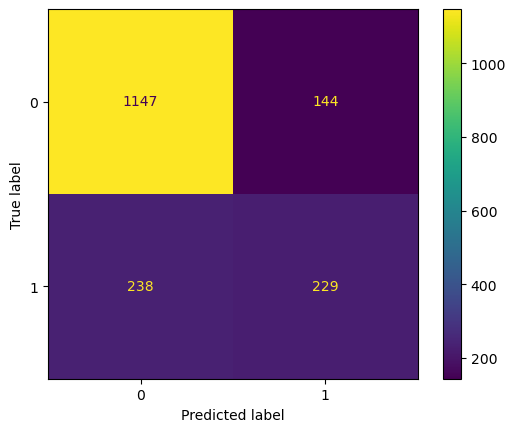

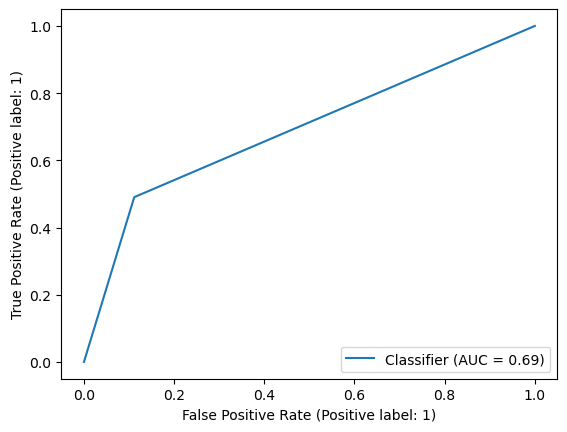

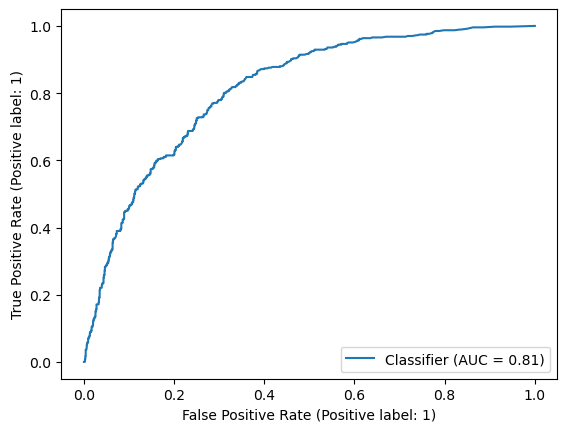

In [436]:
test = RandomForestClassifier(
    criterion='gini',
    n_estimators=599,
    max_depth=19,
    class_weight='balanced',
    random_state=seed
)

test.fit(features_train, target_train)

mentrics_eval(test, features_test, target_test,1,1,1,1)

In [282]:
if __name__ == "__main__":
    clf = RandomForestClassifier(random_state=seed)

    param_distributions = {
        "criterion": optuna.distributions.CategoricalDistribution(['gini', 'entropy', 'log_loss']),
        "n_estimators": optuna.distributions.IntDistribution(100, 1000, step=50),
        "max_depth": optuna.distributions.IntDistribution(1, 20, step=2),
        "class_weight": optuna.distributions.CategoricalDistribution(['balanced', 'balanced_subsample']),
        'min_samples_split': optuna.distributions.IntDistribution(2, 10, step=2),
        'min_samples_leaf': optuna.distributions.IntDistribution(1, 5),
    }

    optuna_search = optuna.integration.OptunaSearchCV(
        clf, param_distributions, n_trials=100, timeout=600, verbose=2
    )

    optuna_search.fit(features_train, target_train)

    print("Best trial:")
    trial = optuna_search.study_.best_trial

    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

/home/qq/miniconda3/lib/python3.9/site-packages/optuna/distributions.py:683: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
/tmp/ipykernel_4607/1376622158.py:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2022-09-15 12:43:03,534] A new study created in memory with name: no-name-f2efb785-3b26-4580-ad68-699622420d03
[I 2022-09-15 12:43:03,535] Searching the best hyperparameters using 8078 samples...
[I 2022-09-15 12:43:07,593] Trial 0 finished with value: 0.7737056677804004 and parameters: {'criterion': 'log_loss', 'n_estimators': 250, 'max_depth': 5, 'class_weight': 'balanced_subsample', 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.7737056677804004.
[I 2022-09-15 12:43:16,999] Trial 1 finished with value: 0.7525374735

Best trial:
  Value:  0.8958894031818042
  Params: 
    criterion: entropy
    n_estimators: 650
    max_depth: 19
    class_weight: balanced_subsample
    min_samples_split: 2
    min_samples_leaf: 1


Metrics:
roc_auc of predictions:       0.6909604791531555
accuracy_test of predictions: 0.7849829351535836


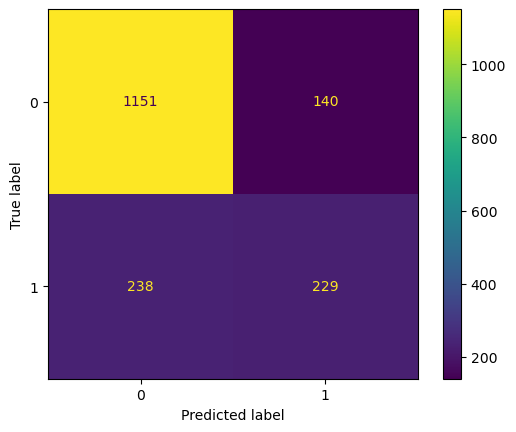

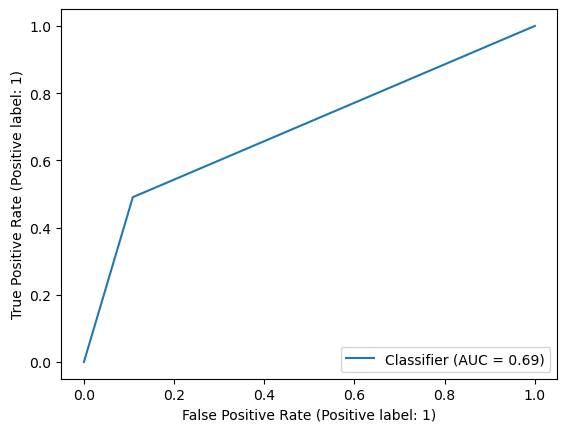

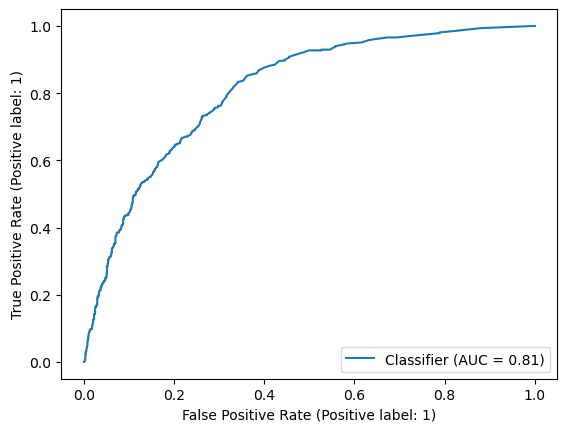

In [437]:
test = RandomForestClassifier(
    criterion='gini',
    n_estimators=150,
    max_depth=21,
    class_weight='balanced',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=seed
)

test.fit(features_train, target_train)

mentrics_eval(test, features_test, target_test,1,1,1,1)

Metrics:
roc_auc of predictions:       0.687178738656852
accuracy_test of predictions: 0.7804323094425484


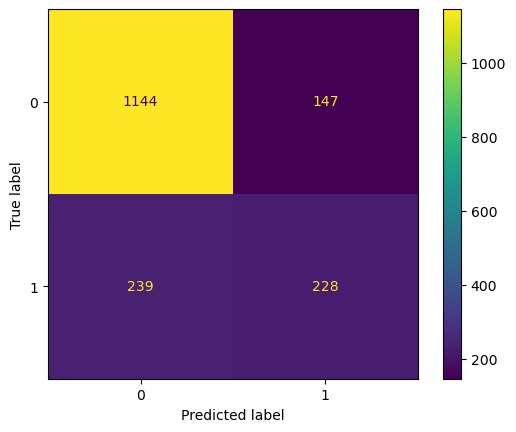

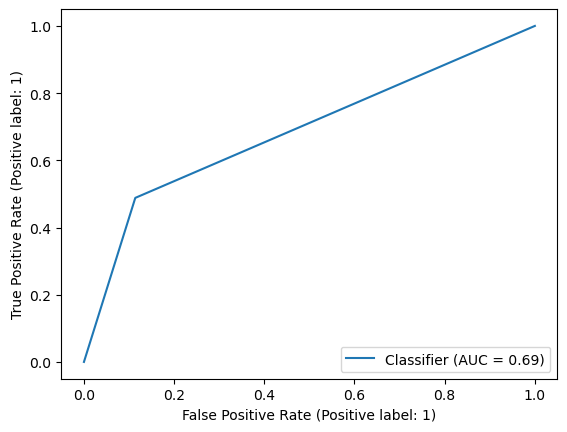

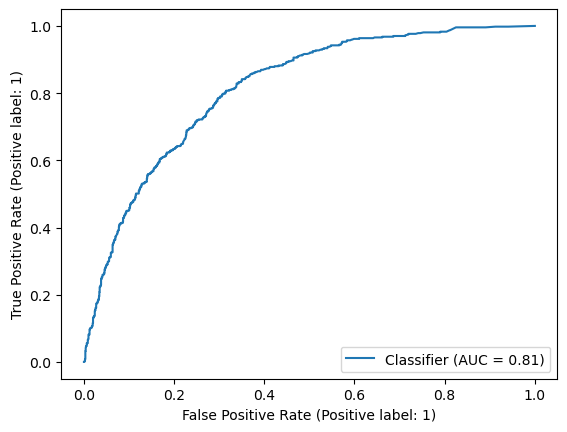

In [438]:
test = RandomForestClassifier(
    criterion='entropy',
    n_estimators=650,
    max_depth=19,
    class_weight='balanced_subsample',
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=seed
)

test.fit(features_train, target_train)

mentrics_eval(test, features_test, target_test,1,1,1,1)

## LightGBM

[LightGBM] [Info] Number of positive: 1122, number of negative: 3097
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 17
[LightGBM] [Info] Number of positive: 1122, number of negative: 3097
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000641 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 385
[LightGBM] [Info] Number of data points in the train set: 4219, number of used features: 17
[LightGBM] [Info] Number of positive: 1121, number of negative: 3098
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing 

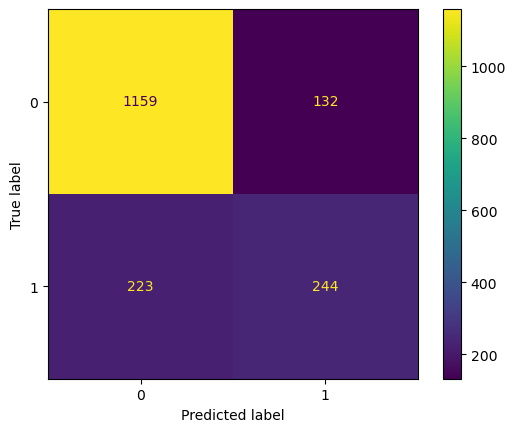

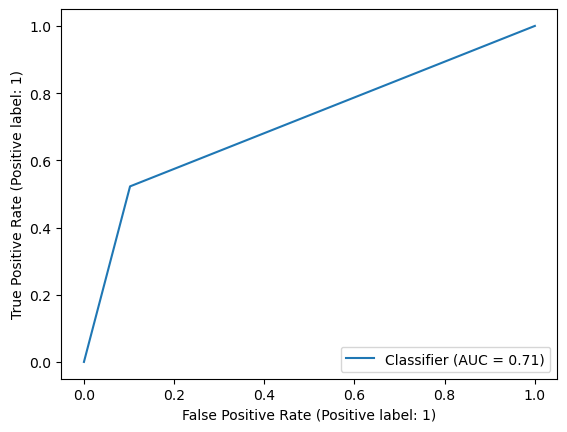

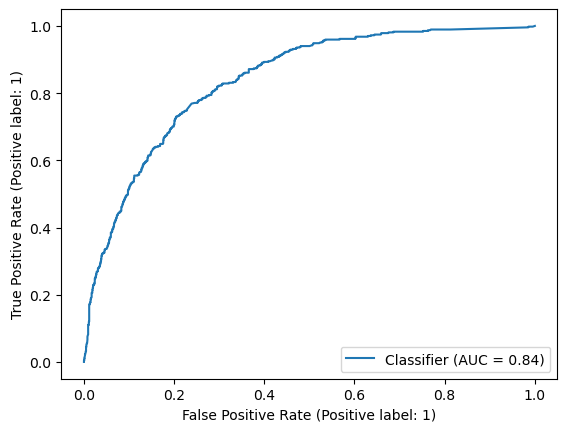

In [507]:
# базовый lightGBM
lgb_train = lgb.Dataset(features_train, target_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'seed': seed
}

gbm = lgb.cv(params,
            lgb_train,
            nfold=5,
            callbacks=[lgb.early_stopping(stopping_rounds=5)],
            return_cvbooster=True)

y_pred = gbm.get('cvbooster').predict(features_test)

roc_auc_test = np.array([])
for i in range(len(y_pred)):
    predicts = list(map(treshhold, y_pred[i]))
    roc_auc_test = np.append(roc_auc_test, roc_auc_score(target_test, predicts))
print(f'roc_auc of prediction for {roc_auc_test.argmax()} booster:')
# берем предикшены лучшей модели
predicts = y_pred[roc_auc_test.argmax()]
mentrics_eval(target=target_test, predictions=predicts,base=1, matrix=1,roc=1, proba=1)

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[22]	cv_agg's auc: 0.844814 + 0.0128446
roc_auc of prediction for 0 booster:
roc_auc of predictions:       0.7271565458113077
accuracy_test of predictions: 0.7889647326507395


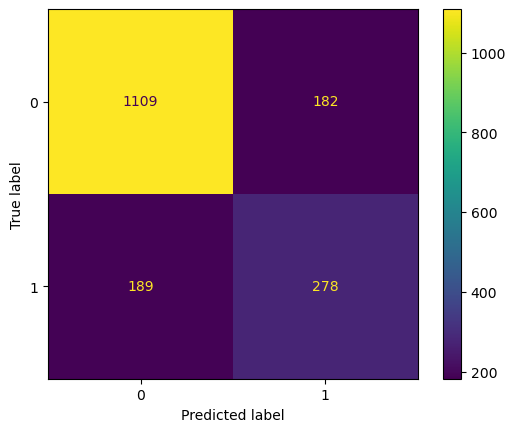

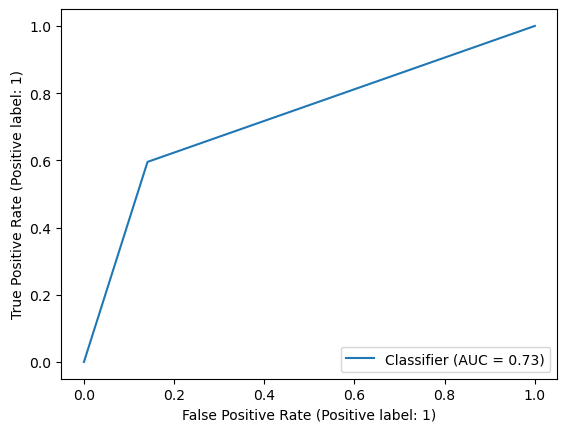

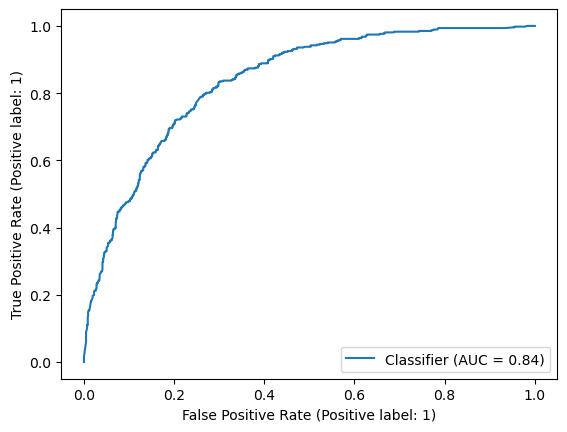

In [503]:
# один из вариантов оптимизации гиперпараметров
lgb_train = lgb.Dataset(features_train, target_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 31,
    'learning_rate': 0.03,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'force_col_wise': True,
    'seed': seed,
    'is_unbalance': True
}

gbm = lgb.cv(params,
            lgb_train,
            nfold=5,
            callbacks=[lgb.early_stopping(stopping_rounds=5)],
            return_cvbooster=True)

y_pred = gbm.get('cvbooster').predict(features_test)

roc_auc_test = np.array([])
for i in range(len(y_pred)):
    predicts = list(map(treshhold, y_pred[i]))
    roc_auc_test = np.append(roc_auc_test, roc_auc_score(target_test, predicts))
print(f'roc_auc of prediction for {roc_auc_test.argmax()} booster:')
# берем предикшены лучшей модели
predicts = y_pred[roc_auc_test.argmax()]
mentrics_eval(target=target_test, predictions=predicts,base=1, matrix=1,roc=1, proba=1)

### Optuna for LightGBM

In [638]:
import optuna.integration.lightgbm as lgb

from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets


if __name__ == "__main__":
    lgb_train = lgb.Dataset(features_train, target_train)

    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

    tuner = lgb.LightGBMTunerCV(
        params,
        lgb_train,
        folds=StratifiedKFold(5, shuffle=True, random_state=seed),
        callbacks=[early_stopping(100), log_evaluation(100)],
        return_cvbooster=True
    )

    tuner.run()

    print("Best score:", tuner.best_score)
    best_params = tuner.best_params
    print("Best params:", best_params)
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

[I 2022-09-15 21:21:12,800] A new study created in memory with name: no-name-029cc694-5cf8-4db7-aac5-dd189b9f1d39
feature_fraction, val_score: -inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's auc: 0.909665 + 0.0100539
[200]	cv_agg's auc: 0.916107 + 0.00834536
[300]	cv_agg's auc: 0.916813 + 0.0082002


feature_fraction, val_score: 0.916985:  14%|#4        | 1/7 [00:01<00:11,  1.84s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.916985 + 0.00833065
[100]	cv_agg's auc: 0.908337 + 0.0104761
[200]	cv_agg's auc: 0.914262 + 0.00919007
[300]	cv_agg's auc: 0.915464 + 0.00906969


feature_fraction, val_score: 0.916985:  29%|##8       | 2/7 [00:03<00:09,  1.80s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.916985 + 0.00833065
[100]	cv_agg's auc: 0.905827 + 0.00926733
[200]	cv_agg's auc: 0.913495 + 0.00865165
[300]	cv_agg's auc: 0.91501 + 0.00803599


feature_fraction, val_score: 0.916985:  43%|####2     | 3/7 [00:05<00:06,  1.71s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.916985 + 0.00833065
[100]	cv_agg's auc: 0.906769 + 0.0106707
[200]	cv_agg's auc: 0.916479 + 0.00848684
[300]	cv_agg's auc: 0.918075 + 0.00828973
[400]	cv_agg's auc: 0.918289 + 0.00813397


feature_fraction, val_score: 0.918521:  57%|#####7    | 4/7 [00:07<00:05,  1.96s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.908356 + 0.0100733
[200]	cv_agg's auc: 0.915741 + 0.00851963
[300]	cv_agg's auc: 0.917845 + 0.00801546
[400]	cv_agg's auc: 0.916905 + 0.00841024


feature_fraction, val_score: 0.918521:  71%|#######1  | 5/7 [00:09<00:04,  2.04s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.909143 + 0.0094791
[200]	cv_agg's auc: 0.916547 + 0.00818494
[300]	cv_agg's auc: 0.916396 + 0.00830552


feature_fraction, val_score: 0.918521:  86%|########5 | 6/7 [00:11<00:02,  2.09s/it]

[400]	cv_agg's auc: 0.917102 + 0.00797242
Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.90537 + 0.00895371
[200]	cv_agg's auc: 0.911461 + 0.0083159
[300]	cv_agg's auc: 0.91279 + 0.00724907
[400]	cv_agg's auc: 0.913649 + 0.00788155


feature_fraction, val_score: 0.918521: 100%|##########| 7/7 [00:15<00:00,  2.18s/it]


Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911


num_leaves, val_score: 0.918521:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.912937 + 0.00876109
[200]	cv_agg's auc: 0.913033 + 0.00884898
[300]	cv_agg's auc: 0.91113 + 0.0088765
[400]	cv_agg's auc: 0.90972 + 0.00919896


num_leaves, val_score: 0.918521:   5%|5         | 1/20 [00:07<02:19,  7.36s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.885352 + 0.0106309
[200]	cv_agg's auc: 0.897781 + 0.0109761
[300]	cv_agg's auc: 0.905226 + 0.00975706
[400]	cv_agg's auc: 0.909521 + 0.00985881


num_leaves, val_score: 0.918521:  10%|#         | 2/20 [00:08<01:04,  3.57s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.914342 + 0.00846185
[200]	cv_agg's auc: 0.914594 + 0.00875138
[300]	cv_agg's auc: 0.912608 + 0.00904567
[400]	cv_agg's auc: 0.911014 + 0.00907871


num_leaves, val_score: 0.918521:  15%|#5        | 3/20 [00:14<01:19,  4.68s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.914688 + 0.00847853
[200]	cv_agg's auc: 0.916844 + 0.00864899
[300]	cv_agg's auc: 0.915863 + 0.00848951
[400]	cv_agg's auc: 0.914098 + 0.00869125


num_leaves, val_score: 0.918521:  20%|##        | 4/20 [00:17<01:07,  4.19s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.914254 + 0.00886426
[200]	cv_agg's auc: 0.915982 + 0.0087337
[300]	cv_agg's auc: 0.915078 + 0.0089504
[400]	cv_agg's auc: 0.913084 + 0.00927924


num_leaves, val_score: 0.918521:  25%|##5       | 5/20 [00:24<01:15,  5.04s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.885352 + 0.0106309
[200]	cv_agg's auc: 0.897781 + 0.0109761
[300]	cv_agg's auc: 0.905226 + 0.00975706
[400]	cv_agg's auc: 0.909521 + 0.00985881


num_leaves, val_score: 0.918521:  30%|###       | 6/20 [00:27<01:01,  4.36s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.913091 + 0.00886453
[200]	cv_agg's auc: 0.913022 + 0.00914838
[300]	cv_agg's auc: 0.911205 + 0.00885063
[400]	cv_agg's auc: 0.909309 + 0.00917778


num_leaves, val_score: 0.918521:  35%|###5      | 7/20 [00:36<01:17,  5.98s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.913405 + 0.00906467
[200]	cv_agg's auc: 0.913541 + 0.00925829
[300]	cv_agg's auc: 0.911685 + 0.0091964
[400]	cv_agg's auc: 0.910061 + 0.00920268


num_leaves, val_score: 0.918521:  40%|####      | 8/20 [00:42<01:12,  6.03s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.91451 + 0.00984604
[200]	cv_agg's auc: 0.915889 + 0.0100048
[300]	cv_agg's auc: 0.915537 + 0.00971793
[400]	cv_agg's auc: 0.913643 + 0.00960957


num_leaves, val_score: 0.918521:  45%|####5     | 9/20 [00:46<00:59,  5.44s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.914342 + 0.00846185
[200]	cv_agg's auc: 0.914594 + 0.00875138
[300]	cv_agg's auc: 0.912608 + 0.00904567
[400]	cv_agg's auc: 0.911014 + 0.00907871


num_leaves, val_score: 0.918521:  50%|#####     | 10/20 [00:52<00:55,  5.53s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.914431 + 0.00924673
[200]	cv_agg's auc: 0.916763 + 0.0094297
[300]	cv_agg's auc: 0.916409 + 0.00888271
[400]	cv_agg's auc: 0.914604 + 0.00866446


num_leaves, val_score: 0.918521:  55%|#####5    | 11/20 [00:55<00:42,  4.74s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.913067 + 0.00970641
[200]	cv_agg's auc: 0.916802 + 0.00895872
[300]	cv_agg's auc: 0.917381 + 0.00925187
[400]	cv_agg's auc: 0.916301 + 0.00874175


num_leaves, val_score: 0.918521:  60%|######    | 12/20 [00:58<00:32,  4.11s/it]

Early stopping, best iteration is:
[347]	cv_agg's auc: 0.918521 + 0.00803911
[100]	cv_agg's auc: 0.912165 + 0.0094647
[200]	cv_agg's auc: 0.918017 + 0.00931297
[300]	cv_agg's auc: 0.918367 + 0.00933808


num_leaves, val_score: 0.918879:  65%|######5   | 13/20 [01:00<00:24,  3.45s/it]

Early stopping, best iteration is:
[263]	cv_agg's auc: 0.918879 + 0.00940584
[100]	cv_agg's auc: 0.912271 + 0.00853015
[200]	cv_agg's auc: 0.917683 + 0.00873922
[300]	cv_agg's auc: 0.918786 + 0.00851878


num_leaves, val_score: 0.919022:  70%|#######   | 14/20 [01:02<00:17,  2.97s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910992 + 0.00926348
[200]	cv_agg's auc: 0.917281 + 0.00873142
[300]	cv_agg's auc: 0.918199 + 0.00807414


num_leaves, val_score: 0.919022:  75%|#######5  | 15/20 [01:03<00:12,  2.56s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910231 + 0.00896819
[200]	cv_agg's auc: 0.917098 + 0.00839137
[300]	cv_agg's auc: 0.918724 + 0.00898365


num_leaves, val_score: 0.919022:  80%|########  | 16/20 [01:05<00:09,  2.26s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.914085 + 0.00872579
[200]	cv_agg's auc: 0.915013 + 0.00882474
[300]	cv_agg's auc: 0.913626 + 0.00894298


num_leaves, val_score: 0.919022:  85%|########5 | 17/20 [01:09<00:08,  2.92s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910401 + 0.0101148
[200]	cv_agg's auc: 0.917101 + 0.00929397
[300]	cv_agg's auc: 0.917843 + 0.00871537


num_leaves, val_score: 0.919022:  90%|######### | 18/20 [01:12<00:05,  2.81s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.914153 + 0.00900714
[200]	cv_agg's auc: 0.916316 + 0.00909789
[300]	cv_agg's auc: 0.916239 + 0.00952134


num_leaves, val_score: 0.919022:  95%|#########5| 19/20 [01:15<00:02,  2.87s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.914149 + 0.00945306
[200]	cv_agg's auc: 0.914914 + 0.00918137
[300]	cv_agg's auc: 0.913999 + 0.00906815


num_leaves, val_score: 0.919022: 100%|##########| 20/20 [01:21<00:00,  4.06s/it]


Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016


bagging, val_score: 0.919022:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.909883 + 0.0098031
[200]	cv_agg's auc: 0.915928 + 0.00925644
[300]	cv_agg's auc: 0.916719 + 0.00872614


bagging, val_score: 0.919022:  10%|#         | 1/10 [00:02<00:21,  2.35s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.907557 + 0.0111616
[200]	cv_agg's auc: 0.91161 + 0.0110545
[300]	cv_agg's auc: 0.913063 + 0.00995757


bagging, val_score: 0.919022:  20%|##        | 2/10 [00:04<00:18,  2.31s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.909394 + 0.00843015
[200]	cv_agg's auc: 0.91383 + 0.00814684
[300]	cv_agg's auc: 0.915615 + 0.00837641


bagging, val_score: 0.919022:  30%|###       | 3/10 [00:06<00:15,  2.26s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.907924 + 0.00794679
[200]	cv_agg's auc: 0.914396 + 0.00802006
[300]	cv_agg's auc: 0.91518 + 0.00833336


bagging, val_score: 0.919022:  40%|####      | 4/10 [00:09<00:13,  2.25s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.900024 + 0.00945373
[200]	cv_agg's auc: 0.908477 + 0.00766082
[300]	cv_agg's auc: 0.909741 + 0.00766476


bagging, val_score: 0.919022:  50%|#####     | 5/10 [00:11<00:11,  2.28s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.905834 + 0.00851343
[200]	cv_agg's auc: 0.910375 + 0.00837997
[300]	cv_agg's auc: 0.911325 + 0.00948361


bagging, val_score: 0.919022:  60%|######    | 6/10 [00:15<00:12,  3.02s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.898044 + 0.00922325
[200]	cv_agg's auc: 0.905708 + 0.00823988
[300]	cv_agg's auc: 0.909424 + 0.00648005


bagging, val_score: 0.919022:  70%|#######   | 7/10 [00:18<00:08,  2.87s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.912271 + 0.00853015
[200]	cv_agg's auc: 0.917683 + 0.00873922
[300]	cv_agg's auc: 0.918786 + 0.00851878


bagging, val_score: 0.919022:  80%|########  | 8/10 [00:20<00:05,  2.58s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.907659 + 0.00988025
[200]	cv_agg's auc: 0.912095 + 0.00963169
[300]	cv_agg's auc: 0.91309 + 0.00965499


bagging, val_score: 0.919022:  90%|######### | 9/10 [00:22<00:02,  2.57s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.906438 + 0.00952252
[200]	cv_agg's auc: 0.912358 + 0.00898972
[300]	cv_agg's auc: 0.913288 + 0.00867522


bagging, val_score: 0.919022: 100%|##########| 10/10 [00:25<00:00,  2.55s/it]


Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016


feature_fraction_stage2, val_score: 0.919022:   0%|          | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.911841 + 0.00892701
[200]	cv_agg's auc: 0.917291 + 0.00911617
[300]	cv_agg's auc: 0.917414 + 0.0090408


feature_fraction_stage2, val_score: 0.919022:  33%|###3      | 1/3 [00:01<00:03,  1.78s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911841 + 0.00892701
[200]	cv_agg's auc: 0.917291 + 0.00911617
[300]	cv_agg's auc: 0.917414 + 0.0090408


feature_fraction_stage2, val_score: 0.919022:  67%|######6   | 2/3 [00:03<00:01,  1.87s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.912271 + 0.00853015
[200]	cv_agg's auc: 0.917683 + 0.00873922
[300]	cv_agg's auc: 0.918786 + 0.00851878


feature_fraction_stage2, val_score: 0.919022: 100%|##########| 3/3 [00:06<00:00,  2.17s/it]


Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016


regularization_factors, val_score: 0.919022:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.909215 + 0.0102425
[200]	cv_agg's auc: 0.915636 + 0.00950555
[300]	cv_agg's auc: 0.916877 + 0.00957451


regularization_factors, val_score: 0.919022:   5%|5         | 1/20 [00:02<00:39,  2.06s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.906273 + 0.00995263
[200]	cv_agg's auc: 0.913561 + 0.00963129
[300]	cv_agg's auc: 0.915618 + 0.00916674


regularization_factors, val_score: 0.919022:  10%|#         | 2/20 [00:03<00:35,  1.96s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911225 + 0.0103347
[200]	cv_agg's auc: 0.916543 + 0.00981818
[300]	cv_agg's auc: 0.917125 + 0.00929079


regularization_factors, val_score: 0.919022:  15%|#5        | 3/20 [00:05<00:31,  1.84s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911022 + 0.00959574
[200]	cv_agg's auc: 0.916845 + 0.00910487
[300]	cv_agg's auc: 0.91819 + 0.00872005


regularization_factors, val_score: 0.919022:  20%|##        | 4/20 [00:07<00:29,  1.83s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911455 + 0.00911289
[200]	cv_agg's auc: 0.916921 + 0.00880607
[300]	cv_agg's auc: 0.918119 + 0.00885497


regularization_factors, val_score: 0.919022:  25%|##5       | 5/20 [00:09<00:26,  1.78s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911945 + 0.0100368
[200]	cv_agg's auc: 0.917201 + 0.00873717
[300]	cv_agg's auc: 0.918029 + 0.00833336


regularization_factors, val_score: 0.919022:  30%|###       | 6/20 [00:10<00:24,  1.78s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910222 + 0.00916872
[200]	cv_agg's auc: 0.915241 + 0.00854107
[300]	cv_agg's auc: 0.916726 + 0.00805588


regularization_factors, val_score: 0.919022:  35%|###5      | 7/20 [00:12<00:22,  1.77s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.91121 + 0.00984762
[200]	cv_agg's auc: 0.916288 + 0.00906434
[300]	cv_agg's auc: 0.916908 + 0.00941452


regularization_factors, val_score: 0.919022:  40%|####      | 8/20 [00:14<00:20,  1.74s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910937 + 0.00957339
[200]	cv_agg's auc: 0.917219 + 0.00869173
[300]	cv_agg's auc: 0.918274 + 0.00875349


regularization_factors, val_score: 0.919022:  45%|####5     | 9/20 [00:17<00:23,  2.13s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911838 + 0.0102193
[200]	cv_agg's auc: 0.917347 + 0.00921958
[300]	cv_agg's auc: 0.918107 + 0.00921061


regularization_factors, val_score: 0.919022:  50%|#####     | 10/20 [00:19<00:20,  2.03s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.892434 + 0.0117745
[200]	cv_agg's auc: 0.898103 + 0.0114198


regularization_factors, val_score: 0.919022:  55%|#####5    | 11/20 [00:20<00:15,  1.77s/it]

[300]	cv_agg's auc: 0.899671 + 0.0112656
Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911709 + 0.0102936
[200]	cv_agg's auc: 0.917695 + 0.00922843
[300]	cv_agg's auc: 0.918526 + 0.00920009


regularization_factors, val_score: 0.919022:  60%|######    | 12/20 [00:22<00:13,  1.75s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910985 + 0.00990299
[200]	cv_agg's auc: 0.916704 + 0.00903301
[300]	cv_agg's auc: 0.917748 + 0.00925016


regularization_factors, val_score: 0.919022:  65%|######5   | 13/20 [00:23<00:12,  1.76s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.912547 + 0.00893532
[200]	cv_agg's auc: 0.916987 + 0.00877587
[300]	cv_agg's auc: 0.918479 + 0.00866145


regularization_factors, val_score: 0.919022:  70%|#######   | 14/20 [00:25<00:10,  1.78s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911959 + 0.0089421
[200]	cv_agg's auc: 0.9174 + 0.00817927
[300]	cv_agg's auc: 0.918407 + 0.0083062


regularization_factors, val_score: 0.919022:  75%|#######5  | 15/20 [00:27<00:08,  1.77s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.910438 + 0.010012
[200]	cv_agg's auc: 0.916402 + 0.00971794
[300]	cv_agg's auc: 0.917161 + 0.00938804


regularization_factors, val_score: 0.919022:  80%|########  | 16/20 [00:29<00:06,  1.74s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911878 + 0.0096992
[200]	cv_agg's auc: 0.918007 + 0.00908016
[300]	cv_agg's auc: 0.918711 + 0.00896927


regularization_factors, val_score: 0.919022:  85%|########5 | 17/20 [00:30<00:05,  1.75s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911524 + 0.00922278
[200]	cv_agg's auc: 0.917211 + 0.00903545
[300]	cv_agg's auc: 0.918019 + 0.0092824


regularization_factors, val_score: 0.919022:  90%|######### | 18/20 [00:32<00:03,  1.78s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.912086 + 0.00902904
[200]	cv_agg's auc: 0.917023 + 0.00916199
[300]	cv_agg's auc: 0.917917 + 0.00880412


regularization_factors, val_score: 0.919022:  95%|#########5| 19/20 [00:34<00:01,  1.79s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.911382 + 0.010295
[200]	cv_agg's auc: 0.916881 + 0.00888077
[300]	cv_agg's auc: 0.91791 + 0.00861552


regularization_factors, val_score: 0.919022: 100%|##########| 20/20 [00:36<00:00,  1.81s/it]


Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016


min_data_in_leaf, val_score: 0.919022:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's auc: 0.896359 + 0.0115889
[200]	cv_agg's auc: 0.904885 + 0.0109668
[300]	cv_agg's auc: 0.909214 + 0.00981752


min_data_in_leaf, val_score: 0.919022:  20%|##        | 1/5 [00:01<00:06,  1.56s/it]

Early stopping, best iteration is:
[267]	cv_agg's auc: 0.919022 + 0.00845016
[100]	cv_agg's auc: 0.913278 + 0.00905147
[200]	cv_agg's auc: 0.92083 + 0.00782736
[300]	cv_agg's auc: 0.922155 + 0.00767489


min_data_in_leaf, val_score: 0.922258:  40%|####      | 2/5 [00:03<00:05,  1.85s/it]

Early stopping, best iteration is:
[296]	cv_agg's auc: 0.922258 + 0.00777364
[100]	cv_agg's auc: 0.913165 + 0.00909122
[200]	cv_agg's auc: 0.920924 + 0.00816455
[300]	cv_agg's auc: 0.92322 + 0.00749125


min_data_in_leaf, val_score: 0.923555:  60%|######    | 3/5 [00:06<00:04,  2.45s/it]

[400]	cv_agg's auc: 0.923376 + 0.00791929
Early stopping, best iteration is:
[311]	cv_agg's auc: 0.923555 + 0.00735326
[100]	cv_agg's auc: 0.910172 + 0.00983616
[200]	cv_agg's auc: 0.915858 + 0.00906623
[300]	cv_agg's auc: 0.91697 + 0.00894087


min_data_in_leaf, val_score: 0.923555:  80%|########  | 4/5 [00:10<00:02,  2.92s/it]

[400]	cv_agg's auc: 0.916527 + 0.00894927
Early stopping, best iteration is:
[311]	cv_agg's auc: 0.923555 + 0.00735326
[100]	cv_agg's auc: 0.902283 + 0.0104533
[200]	cv_agg's auc: 0.910283 + 0.00964306
[300]	cv_agg's auc: 0.913087 + 0.00839896


min_data_in_leaf, val_score: 0.923555: 100%|##########| 5/5 [00:12<00:00,  2.50s/it]

[400]	cv_agg's auc: 0.91375 + 0.00841179
Early stopping, best iteration is:
[311]	cv_agg's auc: 0.923555 + 0.00735326
Best score: 0.9235546741982652
Best params: {'objective': 'binary', 'metric': 'auc', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 47, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 5}
  Params: 
    objective: binary
    metric: auc
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 47
    feature_fraction: 0.4
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 5


[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[17]	cv_agg's auc: 0.841923 + 0.0113105
roc_auc of prediction for 0 booster: 0.7585433332725159
roc_auc of predictions:       0.7585433332725159
accuracy_test of predictions: 0.7627986348122867


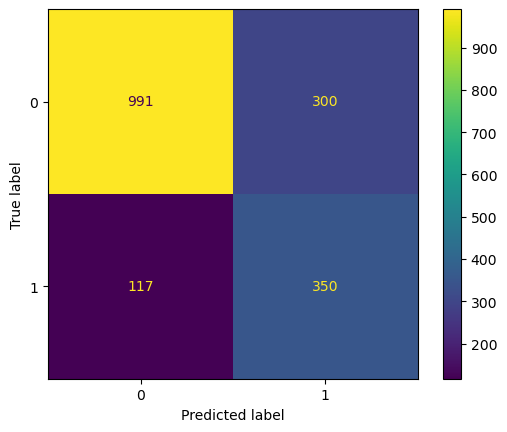

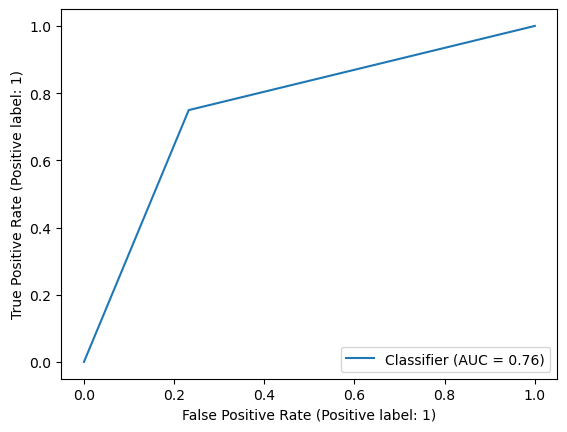

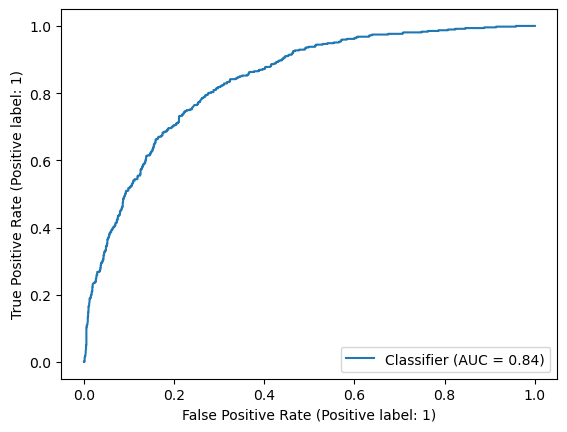

In [512]:
# light_gbm = tuner.get_best_booster()

params = {'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1, 
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'num_leaves': 47,
        'feature_fraction': 0.4,
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'min_child_samples': 5,
        'is_unbalance': True,
        'seed': seed,}

gbm = lgb.cv(params,
            lgb_train,
            nfold=5,
            callbacks=[lgb.early_stopping(stopping_rounds=5)],
            return_cvbooster=True)

y_pred = gbm.get('cvbooster').predict(features_test)


roc_auc_test = np.array([])
for i in range(len(y_pred)):
    predicts = list(map(treshhold, y_pred[i]))
    roc_auc_test = np.append(roc_auc_test, roc_auc_score(target_test, predicts))
print(f'roc_auc of prediction for {roc_auc_test.argmax()} booster: {roc_auc_test.max()}')
# берем предикшены лучшей модели
predicts = y_pred[roc_auc_test.argmax()]
mentrics_eval(target=target_test, predictions=predicts,base=1, matrix=1,roc=1, proba=1)

### лучшая модель

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[59]	cv_agg's auc: 0.849041 + 0.0129515
roc_auc of prediction for 2 booster: 0.7635300888874882
roc_auc of predictions:       0.7635300888874882
accuracy_test of predictions: 0.7440273037542662


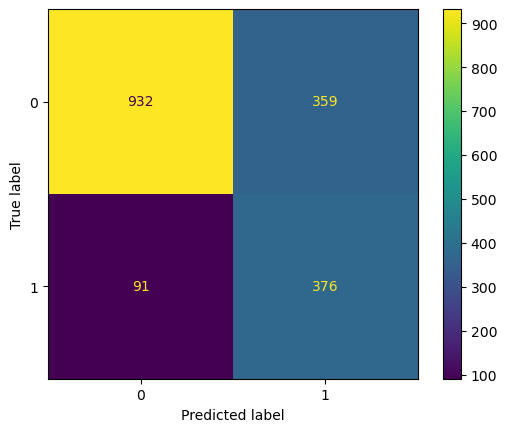

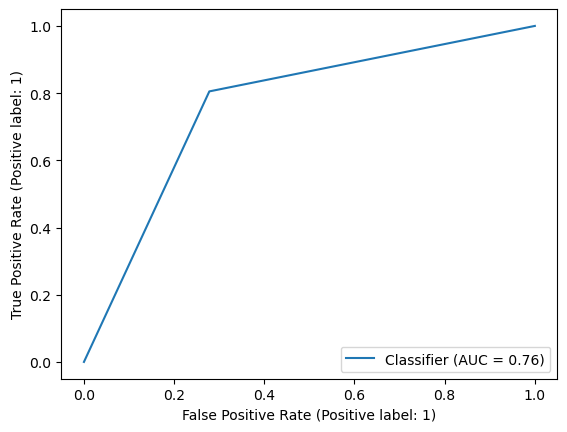

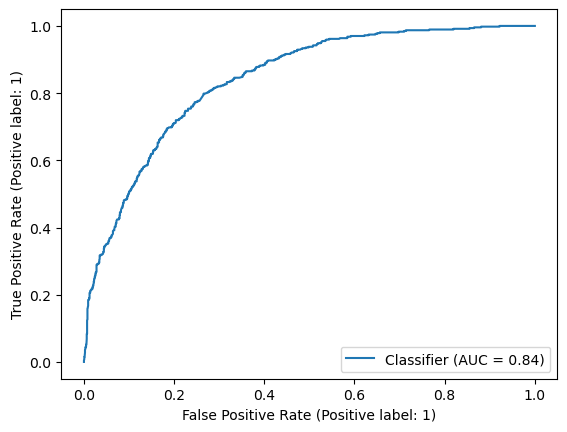

In [561]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(features_train, target_train)


# specify your configurations as a dict
params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 4,
    'min_data_in_leaf': 18,
    'seed': seed,
    'is_unbalance': True,
}

gbm = lgb.cv(params,
            lgb_train,
            nfold=10,
            callbacks=[lgb.early_stopping(stopping_rounds=5)],
            return_cvbooster=True)

y_pred = gbm.get('cvbooster').predict(features_test)

roc_auc_test = np.array([])
for i in range(len(y_pred)):
    predicts = list(map(treshhold, y_pred[i]))
    roc_auc_test = np.append(roc_auc_test, roc_auc_score(target_test, predicts))
print(f'roc_auc of prediction for {roc_auc_test.argmax()} booster: {roc_auc_test.max()}')
# берем предикшены лучшей модели
predicts = y_pred[roc_auc_test.argmax()]
mentrics_eval(target=target_test, predictions=predicts,base=1, matrix=1,roc=1, proba=1)
    

## XGBoost

In [526]:
dtrain = xgb.DMatrix(features_train, label=target_train)
dtest = xgb.DMatrix(features_test)

In [555]:
param = {
    'max_depth': 4, 
    # 'eta': 1,
    # 'objective': 'binary:logistic',
    'eval_metric': 'auc',
    # 'sampling_method': 'gradient_based',
    # 'max_bin': 5000,
    # 'subsample': ,
    # 'colsample_bytree':0.75,
    # 'objective': 'binary:hinge',

}

In [556]:
xgb.cv(param, dtrain, nfold=10, stratified=True, metrics='auc', seed=seed)

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.840370       0.001849       0.825823      0.017242
1        0.847027       0.002494       0.834117      0.016710
2        0.851757       0.002385       0.835900      0.016119
3        0.856826       0.001621       0.839074      0.015483
4        0.860164       0.002247       0.840764      0.014658
5        0.863721       0.002029       0.842197      0.013868
6        0.866695       0.001774       0.843263      0.014561
7        0.869453       0.001651       0.844053      0.013480
8        0.871726       0.001829       0.843834      0.013729
9        0.873593       0.001597       0.843686      0.013519

In [557]:
num_round = 20
bst = xgb.train(param, dtrain, num_round)

roc_auc of predictions:       0.7121913029920534
accuracy_test of predictions: 0.7940841865756542


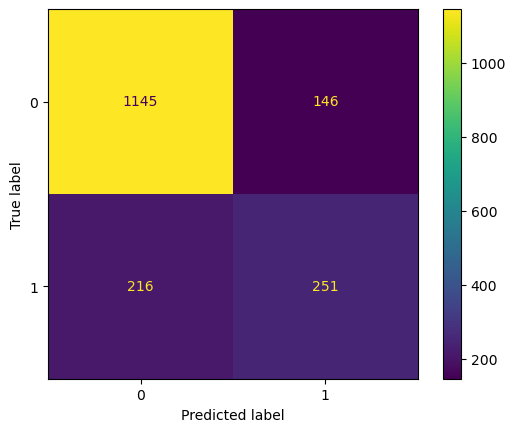

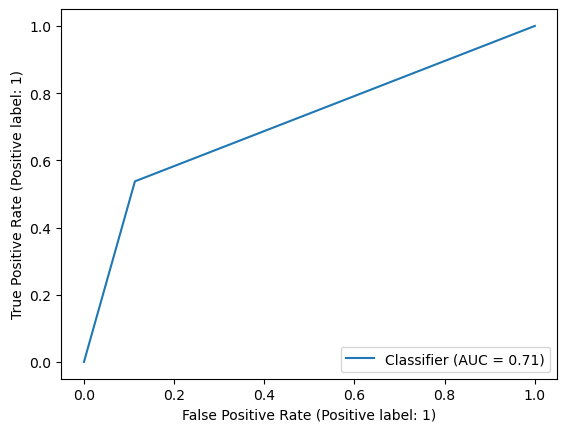

In [558]:
mentrics_eval(bst, dtest, target_test,1,1,1,1)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

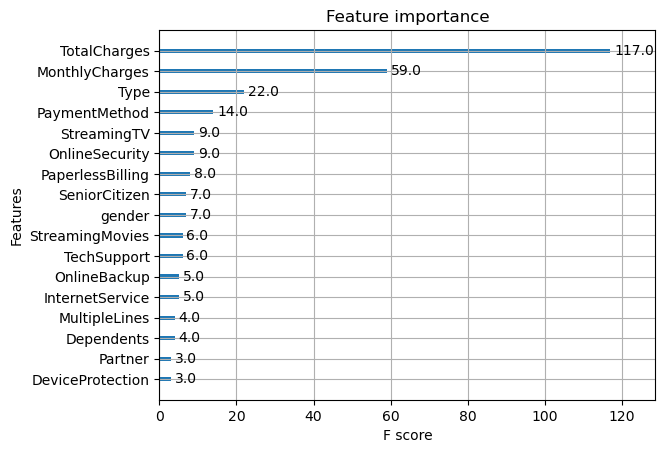

In [559]:
xgb.plot_importance(bst)

### Оптимизация количества деревьев

In [562]:
rounds = np.arange(0,100,1)
auc_final = []

In [563]:
for i in rounds:
    param = {
    # 'max_depth': 3, 
    # 'eta': 1,
    # 'objective': 'binary:logistic',
    'eval_metric': 'auc',
    # 'sampling_method': 'gradient_based',
    # 'max_bin': 5000,
    # 'subsample': ,
    # 'colsample_bytree':0.75,
    'objective': 'binary:hinge',

    }
    num_round = i
    bst = xgb.train(param, dtrain, num_round)


    ypred = bst.predict(dtest)
    auc_final.append(roc_auc_score(target_test, ypred))

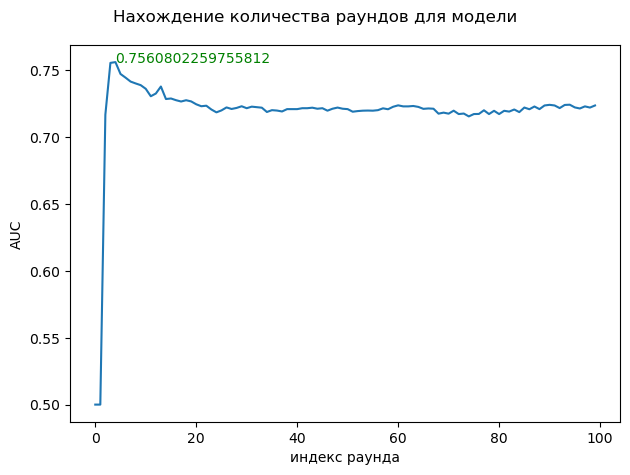

In [564]:
i = pd.Series(auc_final)
best = np.array(auc_final).argmax()

x = i.index
y = i

# plot
fig, ax = plt.subplots()

ax.plot(x, y)

plt.text(best, auc_final[best], auc_final[best], color='g')

fig.suptitle('Нахождение количества раундов для модели')
plt.ylabel('AUC')
plt.xlabel('индекс раунда')
fig.tight_layout()
plt.show()

roc_auc of predictions:       0.7560802259755812
accuracy_test of predictions: 0.7320819112627986


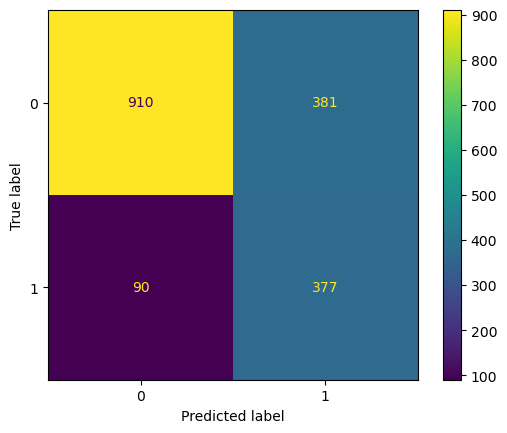

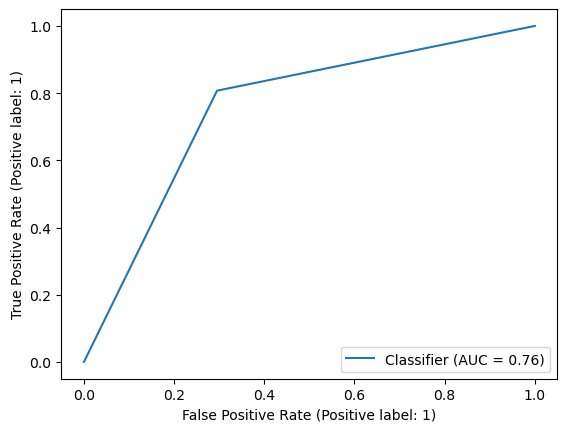

In [567]:
num_round = best
bst = xgb.train(param, dtrain, num_round)

mentrics_eval(bst, dtest, target_test,1,1,1,1)

# Выводы

В исследовании было проведено:
- предобработка данных:
    - использование KNN для заполнения пропущенных данных
    - непрерывные признаки были нормализованы с помощью алгоритма MinMax
- обучение базовых моделей
    - DecisionTree
    - Forest
    - LogisticRegressor
- обучение бустинговых моделей:
    - CatBoost
    - LightGMB
    - XGBoost
- так же было проведено:
    - оценка важности признаков на моделях
        - базовых моделях
        - СatBoost
    - были проведены эксперименты с алгоритмами апсемплинга с последующим использованием CatBoost
        - AllKNN
        - SMOTE
        - SVMSMOTE
        - ADASYN
    - поиск весов для CatBoost
    - использование Optuna для оптимизации гиперпараметров в моделях
        - Forest
        - LightGBM

AUC моделей:
- Tree: 
    - plain — 0.732
    - stritifaid — 0.743
    - features optimisation — 0.730
- Forest: 
    - plain — 0.757
    - stritifaid — 0.760
    - features optimisation — 0.752
    - optuna optimisation:
        - 0.689
        - 0.690
        - 0.687
- Logistic:
    - plain — 0.745
    - stritifaid — 0.745
    - features optimisation — 0.741
- CatBoost
    - plain — 0.765
    - с апсемплингом AllKNN — 0.752
    - с апсемплингом SMOTE — 0.755
    - с апсемплингом SVMSMOTE — 0.754
    - с апсемплингом ADASYN — 0.753
    - алгоритм семплинга SMOTETomek — 0.755
    - оптимизация признаков — 0.745
    - оптимизация весов — 0.766
    - оптимизация весов при использовании алгоритма апсемплинга SVMSMOTE — 0.738
- LightGBM
    - plain — 0.710
    - variant — 0.727
    - stratify optuna — 0.758
    - manual tune — 0.763
- XGBoost
    - plain — 0.712
    - tree optimisation — 0.756

Большинство моделей имеют большое количество ложно положительных предсказаний, что предполагает, что либо нужен иной подход к обучению, либо доработка датасета.
Но при этом ложно отрицательных вариантов минимальное количество по отношению к ложно положительным, в рамках нашей задачи, скорее, можно сказать что это положительный вариант, так как компания не оставит уходящего клиента без предложения в большинстве случаев.